## libraries

In [1]:
import os
import sys
from pathlib import Path
from pprint import pformat
from tempfile import TemporaryDirectory
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import geopandas as gpd
import pooch
import flopy
import flopy.plot
import flopy.utils
import rasterio
from rasterio.features import rasterize
from shapely.geometry import box
import contextily as cx
import re
from shapely.geometry import Point
from multiprocessing import Pool, cpu_count
import time
print(sys.version)
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"flopy version: {flopy.__version__}")

3.11.9 (main, Apr  2 2024, 13:43:44) [GCC 13.2.0]
numpy version: 1.26.3
matplotlib version: 3.9.2
flopy version: 3.9.2


## define simulation

In [2]:
# simulation setup
sim_name = 'rgtihm'
workspace = './model'
sim = flopy.mf6.MFSimulation(
    sim_name=sim_name,
    sim_ws=workspace,
    exe_name='mf6')
gwf = flopy.mf6.ModflowGwf(sim,
                           modelname=sim_name)
print("simulation and gwf packages created.")

simulation and gwf packages created.


## tdis

In [3]:
# tdis (temporal discretization) parameters
nper = 898
start_date = datetime(1940, 3, 1)
perioddata = []
for i in range(nper):
    month_start = start_date + timedelta(days=sum(p[0] for p in perioddata))
    if month_start.month == 12:
        month_end = datetime(month_start.year + 1, 1, 1)
    else:
        month_end = datetime(month_start.year, month_start.month + 1, 1)
    perlen = (month_end - month_start).days
    nstp = 2
    tsmult = 1.0
    perioddata.append((float(perlen), nstp, tsmult))

# create tdis
tdis = flopy.mf6.ModflowTdis(
    sim,
    time_units='days',
    nper=nper,
    perioddata=perioddata,
    start_date_time=start_date.strftime('%Y-%m-%d'),
)
print("tdis package created.")

tdis package created.


## dis

In [8]:
# tried feet units with meter crs, failed due to misalignment; tried rotation from lower-left, shifted grid left
# tried fixing top-left rotation, still misaligned; adopted anchoring rotation at top-left, matching qgis points
# may be use exact qgis corners for precision, ensure grid aligns with real-world data via rasterio

# model crs for spatial reference
model_crs = 'epsg:26913'
xul = 251539.8073999998  # top-left x in meters, matches qgis
yul = 3639665.581800001  # top-left y in meters, matches qgis
angrot = 24.0  # rotation in degrees, matches qgis

# grid setup, all in meters
nlay = 9  # number of layers
nrow = 912  # number of rows
ncol = 328  # number of columns
delr = np.full(ncol, 660.0 * 0.3048)  # cell width in meters (660 ft to m)
delc = np.full(nrow, 660.0 * 0.3048)  # cell height in meters (660 ft to m)
# elevation data paths
top_file = '../owhm/model/2022/Data_Model_Arrays/layers/ElevFtDEMR.txt'
bot_files = [
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_RC2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/TopLSF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_LSF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/TopBSMT_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/BaseBSMT_ft.txt',
]

# load top elevation, convert feet to meters
try:
    top = np.loadtxt(top_file, dtype=float)
    if top.shape != (nrow, ncol):
        print(f"warning: top shape mismatch {top.shape}")
        top = top.reshape(nrow, ncol)[:nrow, :ncol]
    top = np.where(top == -99999, np.nan, top * 0.3048)  # ft to m
except Exception as e:
    print(f"error: loading top - {e}. exiting.")
    import sys
    sys.exit(1)

# load bottom elevations, convert feet to meters
botm = np.zeros((nlay, nrow, ncol), dtype=float)
for lay, bot_file in enumerate(bot_files):
    try:
        data = np.loadtxt(bot_file, dtype=float)
        if data.shape != (nrow, ncol):
            print(f"warning: bot shape mismatch {data.shape}")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        botm[lay] = np.where(data == -99999, np.nan, data * 0.3048)  # ft to m
    except Exception as e:
        print(f"error: loading bot layer {lay} - {e}. exiting.")
        import sys
        sys.exit(1)

# load active area shapefile
shp_path = './shps/active_area.shp'
try:
    gdf = gpd.read_file(shp_path)
    if gdf.crs != model_crs:
        print(f"reprojecting shapefile crs")
        gdf = gdf.to_crs(model_crs)
    if len(gdf) != 1:
        print(f"warning: multiple features, using first")
    geometry = gdf.geometry.iloc[0]
except Exception as e:
    print(f"error: loading shapefile - {e}. exiting.")
    import sys
    sys.exit(1)

# set grid lower-left origin from qgis bottom-left
xll = 326161.8336  # lower-left x, from qgis bl
yll = 3472061.7670000014  # lower-left y, from qgis bl
theta = np.radians(angrot)

# grid coordinates, rotated to match qgis points
x = np.arange(ncol) * delr[0]
y = np.arange(nrow) * delc[0]
X, Y = np.meshgrid(x, y)
X_rot = xll + X * np.cos(theta) - Y * np.sin(theta)
Y_rot = yll + X * np.sin(theta) + Y * np.cos(theta)

# raster bounds in meters
minx, maxx = X_rot.min(), X_rot.max()
miny, maxy = Y_rot.min(), Y_rot.max()

# rasterize active area to define idomain
transform = rasterio.transform.from_bounds(minx, miny, maxx, maxy, ncol, nrow)
raster = rasterize([geometry], out_shape=(nrow, ncol), transform=transform, fill=0, default_value=1, dtype='int32')

# check raster coverage
print(f"active cells: {raster.sum()}/{nrow * ncol}")
print(f"grid bounds: {minx:.2f}, {maxx:.2f}, {miny:.2f}, {maxy:.2f}")
print(f"shapefile bounds: {gdf.total_bounds}")
if raster.sum() == 0:
    print("error: no active cells - check alignment")

# create 3d idomain for all layers
idomain = np.ones((nlay, nrow, ncol), dtype=int) * raster[np.newaxis, :, :]

# verify idomain
print(f"idomain active per layer: {[idomain[lay].sum() for lay in range(nlay)]}")

# method: used geometric transformation with rasterio to align grid and shapefile
# technique: anchored rotation at top-left, matched qgis points for precision
# reason: ensures perfect alignment with real-world data, avoiding misalignment
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
   # length_units=length_units,
    xorigin=xll,
    yorigin=yll,
    angrot=angrot,
)
print("dis set with idomain from shapefile, all layers \ndis package created.")

active cells: 52128/299136
grid bounds: 251621.63, 386256.62, 3472061.77, 3666237.73
shapefile bounds: [ 263314.4498 3490036.7519  357957.0726 3644537.2572]
idomain active per layer: [52128, 52128, 52128, 52128, 52128, 52128, 52128, 52128, 52128]
dis set with idomain from shapefile, all layers 
dis package created.


## dis with extent mask to avoid nan

In [ ]:
# summary: convert mf-owhm rgtihm dis to modflow 6, 9 layers
# load top/botm, convert ft to m, nan from -99999 filled with min thickness
# parallel idomain from shapefiles, spatial joins define active cells
# adjust top/botm for nan and thickness <= 0, ensure continuity
# dis package built for modflow 6, fast and stable simulation
import numpy as np
import flopy
import geopandas as gpd
from shapely.geometry import Point
import pandas as pd
import sys
import time
from multiprocessing import Pool, cpu_count

start_time = time.time()

# model setup
model_crs = 'epsg:26913'
xul = 251539.8073999998
yul = 3639665.581800001
angrot = 24.0
nlay = 9
nrow = 912
ncol = 328
delr = np.full(ncol, 660.0 * 0.3048)
delc = np.full(nrow, 660.0 * 0.3048)
xll = 326161.8336
yll = 3472061.7670000014
theta = np.radians(angrot)

# data paths
top_file = './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/ElevFTDEMR.txt'

bot_files = [
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_RC2_ft.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_USF1_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_USF2_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_MSF1_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_MSF2_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_LSF1_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_LSF2_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_BSMT_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Base_BSMT_.txt'
]

extent_shp_files = [
    None,
    './Sweetkind-2017-data/3DHFM_shapefiles/RC_extent.shp',
    './Sweetkind-2017-data/3DHFM_shapefiles/USF_extent.shp',
    './Sweetkind-2017-data/3DHFM_shapefiles/USF_extent.shp',
    './Sweetkind-2017-data/3DHFM_shapefiles/MSF_extent.shp',
    './Sweetkind-2017-data/3DHFM_shapefiles/MSF_extent.shp',
    './Sweetkind-2017-data/3DHFM_shapefiles/LSF_extent.shp',
    './Sweetkind-2017-data/3DHFM_shapefiles/LSF_extent.shp',
    None
]
# Load elevation data
try:
    top = np.loadtxt(top_file, dtype=float) * 0.3048  # ft to m
    if top.shape != (nrow, ncol):
        top = top.reshape(nrow, ncol)[:nrow, :ncol]
except Exception as e:
    print(f"error: loading top - {e}. exiting.")
    sys.exit(1)

botm = np.zeros((nlay, nrow, ncol), dtype=float)
for lay, bot_file in enumerate(bot_files):
    try:
        data = np.loadtxt(bot_file, dtype=float) * 0.3048
        if data.shape != (nrow, ncol):
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        botm[lay] = data
    except Exception as e:
        print(f"error: loading bot layer {lay} - {e}. exiting.")
        sys.exit(1)

# Grid coordinates (cell centers)
x = (np.arange(ncol) + 0.5) * delr[0]
y = (np.arange(nrow) + 0.5) * delc[0]
X, Y = np.meshgrid(x, y)
X_rot = xll + X * np.cos(theta) - Y * np.sin(theta)
Y_rot = yll + X * np.sin(theta) + Y * np.cos(theta)

# Convert grid to GeoDataFrame for spatial join
points = [Point(x, y) for x, y in zip(X_rot.ravel(), Y_rot.ravel())]
grid_gdf = gpd.GeoDataFrame(geometry=points, crs=model_crs)
grid_gdf['row'] = np.repeat(np.arange(nrow), ncol)
grid_gdf['col'] = np.tile(np.arange(ncol), nrow)

# Load and reproject overall active area (cached)
gdf_active = gpd.read_file('./shps/active_area.shp').to_crs(model_crs)
active_geometry = gdf_active.geometry.iloc[0] if len(gdf_active) == 1 else gdf_active.geometry.unary_union
overall_active = grid_gdf.within(active_geometry).values.reshape(nrow, ncol)
print(f"overall active cells: {overall_active.sum()}/{nrow * ncol}")

# Initialize IDOMAIN
idomain = np.zeros((nlay, nrow, ncol), dtype=int)

# Process each layer
for lay in range(nlay):
    if extent_shp_files[lay] is not None:
        gdf_layer = gpd.read_file(extent_shp_files[lay]).to_crs(model_crs)
        layer_geometry = gdf_layer.geometry.iloc[0] if len(gdf_layer) == 1 else gdf_layer.geometry.unary_union
        layer_mask = grid_gdf.within(layer_geometry).values.reshape(nrow, ncol)
    else:
        layer_mask = np.ones((nrow, ncol), dtype=bool)

    # Set IDOMAIN: active if in active area and layer extent, regardless of -99999
    idomain[lay] = overall_active & layer_mask

    # Handle -99999 only for elevation continuity, not IDOMAIN
    top_lay = top if lay == 0 else botm[lay - 1]
    botm_lay = botm[lay]
    min_thickness = 3.048  # 10 ft in meters as a fallback
    botm[lay] = np.where(botm[lay] == -99999 * 0.3048, top_lay - min_thickness, botm[lay])

    print(f"layer {lay} active cells: {idomain[lay].sum()}/{nrow * ncol}")

# Ensure BOTM continuity
for lay in range(nlay - 1):
    inactive_next = ~idomain[lay + 1]
    botm[lay] = np.where(inactive_next, botm[lay + 1], botm[lay])

# Create DIS package
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    xorigin=xll,
    yorigin=yll,
    angrot=angrot,
)
print(f"DIS package created. Runtime: {time.time() - start_time:.2f} seconds.")

overall active cells: 112576/299136
layer 0 active cells: 112576/299136
layer 1 active cells: 17880/299136


## dis with individual idomains and no spatial join

In [31]:
start_time = time.time()
326202.3, 3472110.6
# model setup
model_crs = 'epsg:26913'
xul = 251539.8073999998
yul = 3639665.581800001
angrot = 24.0
nlay = 9
nrow = 912
ncol = 328
delr = np.full(ncol, 660.0 * 0.3048)
delc = np.full(nrow, 660.0 * 0.3048)
xll = 326161.8336
yll = 3472061.7670000014
theta = np.radians(angrot)

# data paths
top_file = './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/ElevFTDEMR.txt'

bot_files = [
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_RC2_ft.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_USF1_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_USF2_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_MSF1_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_MSF2_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_LSF1_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_LSF2_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Top_BSMT_f.txt',
    './Sweetkind-2017-data/3DHFM_shapefiles/Frmwk_cells/attributes_text/Base_BSMT_.txt'
]
# mask files per hydrogeologic unit
mask_files = {
    0: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/RC1_UC.txt',    # layer 1 (RC)
    1: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_UC.txt',  # layer 2 (USF top)
    2: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_UC.txt',  # layer 3 (USF bot)
    3: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_UC.txt',  # layer 4 (MSF top)
    4: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_UC.txt',  # layer 5 (MSF bot)
    5: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_UC.txt',  # layer 6 (LSF top)
    6: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_UC.txt',  # layer 7 (LSF bot)
    7: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_UC.txt',  # layer 8 (BSMT top)
    8: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_UC.txt'   # layer 9 (BSMT bot)
}

# load active area shapefile
shp_path = './shps/active_area.shp'
try:
    gdf = gpd.read_file(shp_path)
    if gdf.crs != model_crs:
        print(f"reprojecting shapefile crs")
        gdf = gdf.to_crs(model_crs)
    if len(gdf) != 1:
        print(f"warning: multiple features, using first")
    geometry = gdf.geometry.iloc[0]
except Exception as e:
    print(f"error: loading shapefile - {e}. exiting.")
    sys.exit(1)

# grid coordinates (cell centers)
x = (np.arange(ncol) + 0.5) * delr[0]
y = (np.arange(nrow) + 0.5) * delc[0]
X, Y = np.meshgrid(x, y)
X_rot = xll + X * np.cos(theta) - Y * np.sin(theta)
Y_rot = yll + X * np.sin(theta) + Y * np.cos(theta)

# convert grid to geodataframe for spatial join
points = [Point(x, y) for x, y in zip(X_rot.ravel(), Y_rot.ravel())]
grid_gdf = gpd.GeoDataFrame(geometry=points, crs=model_crs)
global_mask = grid_gdf.within(geometry).values.reshape(nrow, ncol)
print(f"global active cells: {global_mask.sum()}/{nrow * ncol}")

# load elevation data
try:
    top = np.loadtxt(top_file, dtype=float) * 0.3048  # ft to m (surface)
    if top.shape != (nrow, ncol):
        top = top.reshape(nrow, ncol)[:nrow, :ncol]
except Exception as e:
    print(f"error: loading top - {e}. exiting.")
    sys.exit(1)

botm = np.zeros((nlay, nrow, ncol), dtype=float)
for lay, bot_file in enumerate(bot_files):
    try:
        data = np.loadtxt(bot_file, dtype=float) * 0.3048
        if data.shape != (nrow, ncol):
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        botm[lay] = data  # keep -99999 * 0.3048 as-is
    except Exception as e:
        print(f"error: loading bot layer {lay} - {e}. exiting.")
        sys.exit(1)

# initialize idomain with global mask (0 or 1)
idomain = np.zeros((nlay, nrow, ncol), dtype=int)  # start with 0 (inactive)
idomain[:, :, :] = global_mask[np.newaxis, :, :]   # apply global mask (0 or 1)

# set idomain for all layers from corresponding masks
for lay, mask_file in mask_files.items():
    try:
        mask = np.loadtxt(mask_file, dtype=int)
        if mask.shape != (nrow, ncol):
            mask = mask.reshape(nrow, ncol)[:nrow, :ncol]
        # combine global mask with layer-specific mask
        idomain[lay] = idomain[lay] & mask  # 0 if either global or layer mask is 0, 1 if both are 1
        print(f"layer {lay + 1} active cells (from mask): {np.sum(idomain[lay] == 1)}/{nrow * ncol}")
    except Exception as e:
        print(f"error: loading mask for layer {lay + 1} - {e}. exiting.")
        sys.exit(1)

# override idomain = -1 where botm is -99999 (pass-through cells)
# override idomain = -1 where botm is approximately -99999 * 0.3048
tolerance = 1e-6  # Small tolerance for floating-point comparison
for lay in range(nlay):
    invalid_cells = np.abs(botm[lay] - (-99999 * 0.3048)) < tolerance
    if invalid_cells.any():
        idomain[lay] = np.where(invalid_cells & (idomain[lay] != 0), -1, idomain[lay])
        print(f"layer {lay + 1} active cells (after -99999 check): {np.sum(idomain[lay] == 1)}/{nrow * ncol}")
        print(f"layer {lay + 1} pass-through cells: {np.sum(idomain[lay] == -1)}")
        
# create dis package (no botm adjustments)
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    xorigin=xll,
    yorigin=yll,
    angrot=angrot,
    length_units="meters"
)
# Export grid to GeoPackage
from shapely.geometry import Point
import geopandas as gpd
x = (np.arange(ncol) + 0.5) * delr[0]
y = (np.arange(nrow) + 0.5) * delc[0]
X, Y = np.meshgrid(x, y)
X_rot = xll + X * np.cos(theta) - Y * np.sin(theta)
Y_rot = yll + X * np.sin(theta) + Y * np.cos(theta)
points = [Point(x, y) for x, y in zip(X_rot.ravel(), Y_rot.ravel())]
data = []
for lay in range(nlay):
    for row in range(nrow):
        for col in range(ncol):
            data.append({
                'layer': lay,
                'row': row,
                'col': nrow - 1 - row,
                'idomain': idomain[lay, row, col],
                'geometry': points[row * ncol + col]
            })
grid_gdf = gpd.GeoDataFrame(data, crs=model_crs)
grid_gdf.to_file('grid.gpkg', driver='GPKG', layer='grid')
print("Grid exported to grid.gpkg")
print(f"dis package created. runtime: {time.time() - start_time:.2f} seconds.")
dis.write()

global active cells: 112576/299136
layer 1 active cells (from mask): 13238/299136
layer 2 active cells (from mask): 34923/299136
layer 3 active cells (from mask): 34923/299136
layer 4 active cells (from mask): 2285/299136
layer 5 active cells (from mask): 2285/299136
layer 6 active cells (from mask): 329/299136
layer 7 active cells (from mask): 329/299136
layer 8 active cells (from mask): 913/299136
layer 9 active cells (from mask): 913/299136
layer 1 active cells (after -99999 check): 180/299136
layer 1 pass-through cells: 13058
layer 2 active cells (after -99999 check): 27890/299136
layer 2 pass-through cells: 7033
layer 3 active cells (after -99999 check): 27890/299136
layer 3 pass-through cells: 7033
layer 4 active cells (after -99999 check): 1189/299136
layer 4 pass-through cells: 1096
layer 5 active cells (after -99999 check): 1189/299136
layer 5 pass-through cells: 1096
layer 6 active cells (after -99999 check): 246/299136
layer 6 pass-through cells: 83
layer 7 active cells (aft

## dis with owhm to mf6 grid transformation (nrow and ncol fix)

In [4]:
## This cell converts the MF-OWHM RGTIHM.dis package to MODFLOW 6 rgtihm.dis, 
## First major issue is the difference in the row and col conventions, OWHM follows MF2k and MF2005 convention with xul and yul as xorigin and yorigin. MF6 uses xll and yll as xorigin and yorigin   

#fixing initial issues with an upside-down map by keeping geological data un-flipped and adjusting visualization coordinates in `grid.gpkg` with a row flip for QGIS.
# units were switched from meters back to feet to match the original MF-OWHM data, avoiding conversion errors, with `length_units="feet"` set and coordinates converted to meters for export.
# global `idomain` enforcement was added to ensure cells outside `active_area.shp` are set to 0, preventing activation by layer masks, with a final override step.
# local `idomain` assignment now respects the global mask, activating cells only where both the mask and `global_mask` are 1.
# pass-through cells (`idomain = -1`) are assigned where `botm` equals -99999 within active areas, using a tolerance check and diagnostic reporting.
# The `top` elevation is rounded up to the nearest whole number in feet using `np.ceil` to align with original data precision.
# negative cell thicknesses were fixed by checking and adjusting `botm` values to ensure a minimum thickness of 0.1 feet across all layers.
# row indices for packages like WEL are converted from MF-OWHM’s top-down to MODFLOW 6’s bottom-up convention to maintain consistency.
# diagnostics were added to monitor `idomain` outside active areas, thickness ranges, and pass-through cell counts for validation.

start_time = time.time()

# model setup
model_crs = 'epsg:26913'  # define coordinate reference system
xul = 251539.8073999998  # upper-left x coordinate in feet
yul = 3639665.581800001  # upper-left y coordinate in feet
angrot = 24.0  # grid rotation angle in degrees
nlay = 9  # number of layers
nrow_owhm = 912  # number of rows from owhm
ncol_owhm = 328  # number of columns from owhm
nrow = nrow_owhm  # set rows for model
ncol = ncol_owhm  # set columns for model
delr = np.full(ncol, 660.0)  # cell width along rows in feet
delc = np.full(nrow, 660.0)  # cell height along columns in feet
xll = 326161.8336 / 0.3048  # lower-left x origin in feet
yll = 3472061.7670000014 / 0.3048  # lower-left y origin in feet
theta = np.radians(angrot)  # convert rotation angle to radians

# data paths
top_file = '../owhm/model/2022/Data_Model_Arrays/layers/ElevFtDEMR.txt'  # path to top elevation file
bot_files = [  # list of bottom elevation files for each layer
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_RC2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_USF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_MSF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/TopLSF1_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Top_LSF2_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/TopBSMT_ft.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/BaseBSMT_ft.txt',
]

mask_files = {  # dictionary of mask files for each layer
    0: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/RC1_UC.txt',
    1: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_UC.txt',
    2: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_UC.txt',
    3: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_UC.txt',
    4: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_UC.txt',
    5: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_UC.txt',
    6: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_UC.txt',
    7: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_UC.txt',
    8: '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_UC.txt'
}

# load active area shapefile
shp_path = './shps/active_area.shp'  # path to active area shapefile
try:
    gdf = gpd.read_file(shp_path)  # read shapefile
    if gdf.crs != model_crs:  # check if crs matches model
        print(f"reprojecting shapefile crs")
        gdf = gdf.to_crs(model_crs)  # reproject to model crs
    if len(gdf) != 1:  # ensure only one feature exists
        print(f"warning: multiple features, using first")
    geometry = gdf.geometry.iloc[0]  # extract geometry of active area
except Exception as e:
    print(f"error: loading shapefile - {e}. exiting.")  # handle errors
    sys.exit(1)

# grid coordinates (cell centers)
x = (np.arange(ncol) + 0.5) * delr[0]  # x coordinates for cell centers
y = (np.arange(nrow) + 0.5) * delc[0]  # y coordinates for cell centers
X, Y = np.meshgrid(x, y)  # create 2d grid of x, y coordinates
X_rot = xll + X * np.cos(theta) - Y * np.sin(theta)  # rotate x coordinates
Y_rot = yll + X * np.sin(theta) + Y * np.cos(theta)  # rotate y coordinates

# convert coordinates to meters for visualization (qgis expects meters)
X_rot_m = X_rot * 0.3048  # convert x coordinates to meters
Y_rot_m = Y_rot * 0.3048  # convert y coordinates to meters

# convert grid to geodataframe for spatial join
points = [Point(x, y) for x, y in zip(X_rot_m.ravel(), Y_rot_m.ravel())]  # create point geometries
grid_gdf = gpd.GeoDataFrame(geometry=points, crs=model_crs)  # create geodataframe
global_mask = grid_gdf.within(geometry).values.reshape(nrow, ncol)  # create mask for active area
print(f"global active cells: {global_mask.sum()}/{nrow * ncol}")  # print number of active cells

# diagnostic: check corner cells
print(f"Top-left (OWHM row 1, col 1): X_rot[0, 0]={X_rot[0, 0]:.2f}, Y_rot[0, 0]={Y_rot[0, 0]:.2f} (ft)")  # print top-left coordinates
print(f"Bottom-left (MF6 row 0): X_rot[911, 0]={X_rot[911, 0]:.2f}, Y_rot[911, 0]={Y_rot[911, 0]:.2f} (ft)")  # print bottom-left coordinates

# load elevation data
try:
    top = np.loadtxt(top_file, dtype=float)  # load top elevation data in feet
    if top.shape != (nrow, ncol):  # check shape
        top = top.reshape(nrow, ncol)[:nrow, :ncol]  # reshape if needed
    top = np.ceil(top)  # round up top elevation to nearest whole number
    print(f"Top elevation range after rounding (feet): min={np.min(top):.2f}, max={np.max(top):.2f}")  # print top elevation range
except Exception as e:
    print(f"error: loading top - {e}. exiting.")  # handle errors
    sys.exit(1)

botm = np.zeros((nlay, nrow, ncol), dtype=float)  # initialize bottom elevation array
for lay, bot_file in enumerate(bot_files):
    try:
        data = np.loadtxt(bot_file, dtype=float)  # load bottom elevation for layer
        if data.shape != (nrow, ncol):  # check shape
            data = data.reshape(nrow, ncol)[:nrow, :ncol]  # reshape if needed
        botm[lay] = data  # assign to botm array
    except Exception as e:
        print(f"error: loading bot layer {lay} - {e}. exiting.")  # handle errors
        sys.exit(1)

# initialize idomain with global mask
idomain = np.zeros((nlay, nrow, ncol), dtype=int)  # create idomain array
idomain[:, :, :] = global_mask[np.newaxis, :, :]  # set initial idomain using global mask
print(f"Initial active cells (global mask): {np.sum(idomain == 1)}/{nlay * nrow * ncol}")  # print initial active cells

# set idomain for all layers from corresponding masks
for lay, mask_file in mask_files.items():
    try:
        mask = np.loadtxt(mask_file, dtype=int)  # load mask for layer
        if mask.shape != (nrow, ncol):  # check shape
            mask = mask.reshape(nrow, ncol)[:nrow, :ncol]  # reshape if needed
        idomain[lay] = np.where((mask == 1) & (global_mask == 1), 1, idomain[lay])  # set idomain where mask and global mask are 1
        print(f"layer {lay + 1} active cells (from mask): {np.sum(idomain[lay] == 1)}/{nrow * ncol}")  # print active cells per layer
    except Exception as e:
        print(f"error: loading mask for layer {lay + 1} - {e}. exiting.")  # handle errors
        sys.exit(1)

# override idomain = -1 for pass-through cells
tolerance = 1e-6  # tolerance for invalid cells
for lay in range(nlay):
    invalid_cells = np.abs(botm[lay] - (-99999)) < tolerance  # identify invalid cells
    if invalid_cells.any():
        idomain[lay] = np.where(invalid_cells & (idomain[lay] == 1), -1, idomain[lay])  # set pass-through cells
        print(f"layer {lay + 1} active cells (after -99999 check): {np.sum(idomain[lay] == 1)}/{nrow * ncol}")  # print active cells
        print(f"layer {lay + 1} pass-through cells: {np.sum(idomain[lay] == -1)}")  # print pass-through cells

# reapply global idomain to enforce 0 outside active area
for lay in range(nlay):
    idomain[lay] = np.where(global_mask == 0, 0, idomain[lay])  # set idomain to 0 outside active area
    print(f"layer {lay + 1} active cells (after global enforcement): {np.sum(idomain[lay] == 1)}/{nrow * ncol}")  # print active cells
    print(f"layer {lay + 1} pass-through cells: {np.sum(idomain[lay] == -1)}")  # print pass-through cells

# diagnostic: check for idomain = 1 outside active area
for lay in range(nlay):
    ones_outside_active = np.sum((idomain[lay] == 1) & (global_mask == 0))  # count cells outside active area
    print(f"Layer {lay + 1}: idomain = 1 outside active area: {ones_outside_active} cells")  # print diagnostic result

# create dis package
dis = flopy.mf6.ModflowGwfdis(
    gwf,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,  # use top elevation
    botm=botm,  # use bottom elevation
    idomain=idomain,  # use idomain array
    xorigin=xll,  # set x origin
    yorigin=yll,  # set y origin
    angrot=angrot,  # set rotation angle
    length_units="feet"  # specify length units
)

# export grid to geopackage
from shapely.geometry import Point
import geopandas as gpd

points = [Point(x, y) for x, y in zip(X_rot_m.ravel(), Y_rot_m.ravel())]  # create point geometries
data = []
for lay in range(nlay):
    for row in range(nrow):
        row_owhm = row + 1  # set 1-based top-down row index (owhm)
        row_mf6 = nrow - 1 - (row_owhm - 1)  # convert to 0-based bottom-up row index (mf6)
        for col in range(ncol):
            col_owhm = col + 1  # set 1-based column index
            data.append({
                'layer': lay,
                'row_mf6': row_mf6,
                'row_owhm': row_owhm,
                'col_mf6': col,
                'col_owhm': col_owhm,
                'idomain': idomain[lay, row, col],  # assign idomain value
                'top_ft': top[row, col],  # assign top elevation
                'geometry': points[row * ncol + col]  # assign geometry point
            })
grid_gdf = gpd.GeoDataFrame(data, crs=model_crs)  # create geodataframe
grid_gdf.to_file('grid.gpkg', driver='GPKG', layer='grid')  # export to geopackage
print("Grid exported to grid.gpkg")  # confirm export


print(f"dis package created. runtime: {time.time() - start_time:.2f} seconds.")  
dis.write()
print("dis package written successfully.")

global active cells: 112576/299136
Top-left (OWHM row 1, col 1): X_rot[0, 0]=1070252.00, Y_rot[0, 0]=11391714.46 (ft)
Bottom-left (MF6 row 0): X_rot[911, 0]=825697.53, Y_rot[911, 0]=11940992.80 (ft)
Top elevation range after rounding (feet): min=3638.00, max=7465.00
Initial active cells (global mask): 1013184/2692224
layer 1 active cells (from mask): 112576/299136
layer 2 active cells (from mask): 112576/299136
layer 3 active cells (from mask): 112576/299136
layer 4 active cells (from mask): 112576/299136
layer 5 active cells (from mask): 112576/299136
layer 6 active cells (from mask): 112576/299136
layer 7 active cells (from mask): 112576/299136
layer 8 active cells (from mask): 112576/299136
layer 9 active cells (from mask): 112576/299136
layer 1 active cells (after -99999 check): 13238/299136
layer 1 pass-through cells: 99338
layer 2 active cells (after -99999 check): 48235/299136
layer 2 pass-through cells: 64341
layer 3 active cells (after -99999 check): 48235/299136
layer 3 pass-

## oc 

In [5]:
# create oc (output control) package - defines output data to save or print
oc = flopy.mf6.ModflowGwfoc(
    gwf,  # link to groundwater flow model
    budget_filerecord=f'{sim_name}.cbc',  # set budget output file name - saves cell-by-cell budget data
    head_filerecord=f'{sim_name}.hds',  # set head output file name - saves head data
    headprintrecord=[('COLUMNS', 10, 'WIDTH', 15, 'DIGITS', 6, 'GENERAL')],  # define head printing format - columns, width, digits, and format type
    saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],  # save heads and budgets for all time steps - specifies data to save
    printrecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],  # print heads and budgets for all time steps - specifies data to print to listing file
)
print("oc package created.") 

oc package created.


## ims

In [6]:
# iterative model solutions package -- controls iterative solution of linear and nonlinear equations
#  controls solver settings
ims = flopy.mf6.ModflowIms(
    sim,  # link to simulation
    pname='ims',  # set package name
    complexity='simple',  # set solver complexity - uses simple defaults
    outer_dvclose=1e-4,  # set outer iteration closure criterion (head change)
    outer_maximum=500,  # set max number of outer iterations
    inner_maximum=100,  # set max number of inner iterations per outer iteration
    inner_dvclose=1e-4,  # set inner iteration closure criterion (head change)
    rcloserecord=0.001,  # set residual closure criterion for flow balance
    linear_acceleration='cg',  # set linear acceleration method - conjugate gradient
    relaxation_factor=0.97,  # set relaxation factor for solver stability
)
print("ims package created.")  

ims package created.


## ic

In [7]:
# key info: specifies initial heads for the model
# grid dimensions (from dis)
nlay = 9
nrow = 912
ncol = 328

# head file paths (relative to rgtihm-main/model)
head_files = [
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY1.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY2.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY3.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY4.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY5.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY6.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY7.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY8.txt',
    '../owhm/model/2022/Data_Model_Arrays/layers/Initial_Head/WLCLY9.txt',
]

default_head = 0.0
strt = np.ones((nlay, nrow, ncol), dtype=float) * default_head

# read heads into 3d array
for lay, head_file in enumerate(head_files):
    try:
        data = np.loadtxt(head_file, dtype=float)
        if data.shape != (nrow, ncol):
            print(f"warning: {head_file} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        strt[lay] = data
    except FileNotFoundError:
        print(f"error: {head_file} not found. IC requires this file. Exiting.")
        raise FileNotFoundError(f"Error: {head_file} not found.")
    except Exception as e:
        print(f"error reading {head_file}: {e}. Exiting.")
        raise Exception(f"Error reading {head_file}: {e}")

# apply idomain from dis package
idomain = dis.idomain.array
mask_active = idomain == 1

# fix strt for active cells
top = dis.top.array
botm = dis.botm.array
for lay in range(nlay):
    active_mask = mask_active[lay]
    invalid_heads = (strt[lay] == -999) & active_mask
    if invalid_heads.any():
        default_head = (top[active_mask] + botm[lay][active_mask]) / 2 if lay == 0 else \
                       (botm[lay-1][active_mask] + botm[lay][active_mask]) / 2
        strt[lay][invalid_heads] = default_head[invalid_heads[active_mask]]
    strt[lay][active_mask] = np.clip(strt[lay][active_mask], botm[lay][active_mask], top[active_mask])

# verify strt
print("NaN in strt:", np.isnan(strt).any())
for lay in range(nlay):
    strt_active = strt[lay][mask_active[lay]]
    print(f"Layer {lay + 1} strt (active) min/max:", 
          strt_active.min() if len(strt_active) > 0 else "No active cells", 
          strt_active.max() if len(strt_active) > 0 else "No active cells")

# create ic package
ic = flopy.mf6.ModflowGwfic(gwf, strt=strt)
print(f"ic package created. runtime: {time.time() - start_time:.2f} seconds")
print("ic package created with -999 treated as nodata by applying idomain from .dis")

NaN in strt: False
Layer 1 strt (active) min/max: 3738.0040000000004 4142.873
Layer 2 strt (active) min/max: 3738.717 5101.0
Layer 3 strt (active) min/max: 3748.097 5096.0
Layer 4 strt (active) min/max: 3748.058 5092.0
Layer 5 strt (active) min/max: 3748.049 5089.0
Layer 6 strt (active) min/max: 3747.913 5087.0
Layer 7 strt (active) min/max: 3747.817 5084.0
Layer 8 strt (active) min/max: 3747.805 5082.0
Layer 9 strt (active) min/max: 3747.795 4831.84
ic package created. runtime: 69.60 seconds
ic package created with -999 treated as nodata by applying idomain from .dis


## wel (excluding wells in idomain -1)

In [16]:
# key info: specifies well locations and pumping rates
# dir
well_folder = '../owhm/model/2022/Data_FeedFiles/WEL'

# model setup (reused from DIS conversion)
model_crs = 'epsg:26913'  # UTM Zone 13N, NAD83
xul = 251539.8073999998  # upper-left x in feet
yul = 3639665.581800001  # upper-left y in feet
angrot = 24.0  # grid rotation angle in degrees
nlay = 9  # number of layers
nrow_owhm = 912  # number of rows from MF-OWHM
ncol_owhm = 328  # number of columns from MF-OWHM
nrow = nrow_owhm  # set rows for model
ncol = ncol_owhm  # set columns for model
delr = np.full(ncol, 660.0)  # cell width along rows in feet
delc = np.full(nrow, 660.0)  # cell height along columns in feet
xll = 326161.8336 / 0.3048  # lower-left x origin in feet
yll = 3472061.7670000014 / 0.3048  # lower-left y origin in feet
theta = np.radians(angrot)  # convert rotation angle to radians

# read well files
well_files = [f for f in os.listdir(well_folder) if f.endswith('_FEED.txt')]
print(f"found {len(well_files)} well files: {well_files}")

from multiprocessing import Pool

def is_float(value):
    # check if a string can be converted to float
    try:
        float(value)
        return True
    except ValueError:
        return False

def process_well_file(well_file):
    # process individual well file
    file_path = os.path.join(well_folder, well_file)
    temp_locations = []
    temp_flux = []
    reading_locations = True

    with open(file_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        if 'TEMPORAL INPUT' in line:
            reading_locations = False
            continue
        if reading_locations:
            if line.strip() and not line.startswith('#'):
                parts = line.split()
                layer_mf6 = int(parts[0]) - 1  # convert to 0-based
                row_mf6 = int(parts[1]) - 1    # convert to 0-based, assume already bottom-up
                col_mf6 = int(parts[2]) - 1    # convert to 0-based
                # validate bounds
                if layer_mf6 >= nlay or row_mf6 >= nrow or col_mf6 >= ncol:
                    print(f"warning: well {parts[3]} at mf6 ({layer_mf6}, {row_mf6}, {col_mf6}) "
                          f"exceeds grid dimensions ({nlay}, {nrow}, {ncol})")
                    continue
                well_name = parts[3].strip()
                temp_locations.append({
                    'layer_mf6': layer_mf6,
                    'row_mf6': row_mf6,
                    'col_mf6': col_mf6,
                    'name': well_name
                })
        else:
            if line.strip() and not line.startswith('#'):
                parts = line.split()
                flux = []
                for x in parts:
                    if not x.startswith('#') and is_float(x):
                        flux.append(float(x) if x.lower() != 'nan' else 0.0)
                if flux:
                    temp_flux.append(flux)

    # align flux data with locations
    if temp_flux:
        max_len = len(temp_locations)
        temp_flux = [f + [0.0] * (max_len - len(f)) if len(f) < max_len else f[:max_len] for f in temp_flux]
    else:
        temp_flux = [[0.0] * len(temp_locations) for _ in range(1)]  # at least one stress period

    unique_names_in_file = set(loc['name'] for loc in temp_locations)
    print(f"file: {well_file}, wells: {len(temp_locations)}, unique names: {unique_names_in_file}")
    return temp_locations, temp_flux

# use pool to parallelize file processing
with Pool() as p:
    results = p.map(process_well_file, well_files)

well_locations = []
flux_data = []
well_count = 0
current_well_count = 0

for temp_locations, temp_flux in results:
    well_locations.extend(temp_locations)
    new_well_count = len(temp_locations)
    if not flux_data:
        # initialize flux_data with the first temp_flux
        flux_data = [[0.0] * current_well_count + f for f in temp_flux]
    else:
        # pad existing flux_data and append new fluxes
        max_sp = max(len(flux_data), len(temp_flux))
        flux_data = [flux_data[i] + [0.0] * new_well_count if i < len(flux_data) else [0.0] * current_well_count + [0.0] * new_well_count for i in range(max_sp)]
        for i in range(len(temp_flux)):
            if i < len(flux_data):
                flux_data[i] = flux_data[i][:current_well_count] + temp_flux[i]
            else:
                flux_data.append([0.0] * current_well_count + temp_flux[i])
    current_well_count += new_well_count
    well_count += new_well_count

# exclude wells not in idomain 1
valid_well_locations = []
valid_flux_data = [[] for _ in range(len(flux_data))]
for i, well in enumerate(well_locations):
    if dis.idomain.array[well['layer_mf6'], well['row_mf6'], well['col_mf6']] == 1:
        valid_well_locations.append(well)
        # collect corresponding flux data for valid wells
        for j in range(len(flux_data)):
            if i < len(flux_data[j]):  # safe indexing
                valid_flux_data[j].append(flux_data[j][i])
            else:
                valid_flux_data[j].append(0.0)

well_locations = valid_well_locations
flux_data = valid_flux_data
well_count = len(well_locations)
print(f"number of wells outside idomain 1: {current_well_count - len(valid_well_locations)}")
print(f"after excluding, total wells in idomain 1: {well_count}")

print(f"total wells read: {well_count}")
print(f"total flux data rows: {len(flux_data)}")
print("first 5 wells (MF6 indices):")
for well in well_locations[:5]:
    print(f"well {well['name']}: mf6 ({well['layer_mf6']}, {well['row_mf6']}, {well['col_mf6']})")
unique_well_names = set(well['name'] for well in well_locations)
print(f"combined unique well names: {unique_well_names}")

# prepare stress period data
stress_period_data = {}
previous_flux = None

for sp in range(min(nper, len(flux_data))):
    current_flux = flux_data[sp]
    if sp == 0 or current_flux != previous_flux:
        stress_period_data[sp] = []
        for idx, well in enumerate(well_locations):
            if idx < len(current_flux) and current_flux[idx] != 0.0:
                well_tuple = ((well['layer_mf6'], well['row_mf6'], well['col_mf6']), current_flux[idx], well['name'])
                stress_period_data[sp].append(well_tuple)
    previous_flux = current_flux

if not stress_period_data:
    raise ValueError("error: stress_period_data is empty!")
else:
    for sp in range(min(nper, 5)):
        if sp in stress_period_data:
            print(f"stress period {sp} data (mf6 indices): {stress_period_data[sp][:5]}")

# export wells to geopackage
# get grid information from DIS package
try:
    xll = float(dis.xorigin.data) if hasattr(dis.xorigin, 'data') else float(dis.xorigin)
except AttributeError:
    xll = float(dis.xorigin)
try:
    yll = float(dis.yorigin.data) if hasattr(dis.yorigin, 'data') else float(dis.yorigin)
except AttributeError:
    yll = float(dis.yorigin)
try:
    angrot = float(dis.angrot.data) if hasattr(dis.angrot, 'data') else float(dis.angrot)
except AttributeError:
    angrot = float(dis.angrot)

# use uniform delr and delc from DIS setup
delr = delr[0]  # uniform cell width
delc = delc[0]  # uniform cell height

# create a list of dictionaries for the GeoDataFrame
well_data = []
for idx, well in enumerate(well_locations):
    # compute x, y coordinates (center of cell) in model coordinate system (feet)
    x = xll + (well['col_mf6'] + 0.5) * delr
    y = yll + (nrow - 1 - well['row_mf6'] + 0.5) * delc  # adjust for bottom-up indexing
    
    # apply rotation
    theta = np.radians(angrot)
    x_rot = xll + (x - xll) * np.cos(theta) - (y - yll) * np.sin(theta)
    y_rot = yll + (x - xll) * np.sin(theta) + (y - yll) * np.cos(theta)
    x, y = x_rot, y_rot
    
    # convert to meters for geopackage export (QGIS expects meters)
    x_m = x * 0.3048
    y_m = y * 0.3048
    
    # collect attributes
    well_attrs = {
        'name': well['name'],
        'layer_mf6': well['layer_mf6'],
        'row_mf6': well['row_mf6'],
        'col_mf6': well['col_mf6'],
        'geometry': Point(x_m, y_m)
    }
    # add flux values for each stress period
    for sp in range(min(nper, len(flux_data))):
        flux = flux_data[sp][idx] if idx < len(flux_data[sp]) else 0.0
        well_attrs[f'flux_sp{sp}'] = flux
    well_data.append(well_attrs)

# create GeoDataFrame
gdf = gpd.GeoDataFrame(well_data, geometry='geometry')
gdf.crs = model_crs  # set CRS to match model (epsg:26913)

# export to geopackage
gdf.to_file('well_locations.gpkg', driver='GPKG', layer='wells')
print("exported wells to well_locations.gpkg")

# create wel package
wel = flopy.mf6.ModflowGwfwel(
    gwf,
    pname='wel',
    stress_period_data=stress_period_data,
    save_flows=True,
    boundnames=True,
    print_input=True
)
wel.write()
print("wel package created successfully.")

found 8 well files: ['MX_MnI_FEED.txt', 'NM_PDL_FEED.txt', 'NM_DOM_FEED.txt', 'NM_DOL_FEED.txt', 'NM_DCN_FEED.txt', 'NM_PDM_FEED.txt', 'TX_DOM_FEED.txt', 'NM_CLS_FEED.txt']
file: NM_DCN_FEED.txt, wells: 3, unique names: {'WEL_DOM_NM'}
file: MX_MnI_FEED.txt, wells: 33, unique names: {'WEL_MNI_MX'}
file: TX_DOM_FEED.txt, wells: 60, unique names: {'WEL_DOM_TX'}file: NM_CLS_FEED.txt, wells: 85, unique names: {'WEL_DOM_NM'}

file: NM_PDL_FEED.txt, wells: 73, unique names: {'WEL_DOM_NM'}
file: NM_DOL_FEED.txt, wells: 166, unique names: {'WEL_DOM_NM'}
file: NM_PDM_FEED.txt, wells: 1308, unique names: {'WEL_DOM_NM'}
file: NM_DOM_FEED.txt, wells: 7182, unique names: {'WEL_DOM_NM'}
number of wells outside idomain 1: 1442
after excluding, total wells in idomain 1: 7468
total wells read: 7468
total flux data rows: 922
first 5 wells (MF6 indices):
well WEL_MNI_MX: mf6 (2, 805, 155)
well WEL_MNI_MX: mf6 (2, 825, 139)
well WEL_MNI_MX: mf6 (2, 758, 93)
well WEL_MNI_MX: mf6 (2, 733, 109)
well WEL_MNI_M

## wel (including but commenting out wells in idomain -1)

In [17]:

# key info: specifies well locations and pumping rates

start_time = time.time()  # record start time
# dir
well_folder = '../owhm/model/2022/Data_FeedFiles/WEL'

# model setup (reused from DIS conversion)
model_crs = 'epsg:26913'  # UTM Zone 13N, NAD83
xul = 251539.8073999998  # upper-left x in feet
yul = 3639665.581800001  # upper-left y in feet
angrot = 24.0  # grid rotation angle in degrees
nlay = 9  # number of layers
nrow_owhm = 912  # number of rows from MF-OWHM
ncol_owhm = 328  # number of columns from MF-OWHM
nrow = nrow_owhm  # set rows for model
ncol = ncol_owhm  # set columns for model
delr = np.full(ncol, 660.0)  # cell width along rows in feet
delc = np.full(nrow, 660.0)  # cell height along columns in feet
xll = 326161.8336 / 0.3048  # lower-left x origin in feet
yll = 3472061.7670000014 / 0.3048  # lower-left y origin in feet
theta = np.radians(angrot)  # convert rotation angle to radians

# read well files
well_files = [f for f in os.listdir(well_folder) if f.endswith('_FEED.txt')]
print(f"found {len(well_files)} well files: {well_files}")

from multiprocessing import Pool

def is_float(value):
    # check if a string can be converted to float
    try:
        float(value)
        return True
    except ValueError:
        return False

def process_well_file(well_file):
    # process individual well file
    file_path = os.path.join(well_folder, well_file)
    temp_locations = []
    temp_flux = []
    reading_locations = True

    with open(file_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        if 'TEMPORAL INPUT' in line:
            reading_locations = False
            continue
        if reading_locations:
            if line.strip() and not line.startswith('#'):
                parts = line.split()
                layer_mf6 = int(parts[0]) - 1  # convert to 0-based
                row_mf6 = int(parts[1]) - 1    # convert to 0-based, assume already bottom-up
                col_mf6 = int(parts[2]) - 1    # convert to 0-based
                # validate bounds
                if layer_mf6 >= nlay or row_mf6 >= nrow or col_mf6 >= ncol:
                    print(f"warning: well {parts[3]} at mf6 ({layer_mf6}, {row_mf6}, {col_mf6}) "
                          f"exceeds grid dimensions ({nlay}, {nrow}, {ncol})")
                    continue
                well_name = parts[3].strip()
                temp_locations.append({
                    'layer_mf6': layer_mf6,
                    'row_mf6': row_mf6,
                    'col_mf6': col_mf6,
                    'name': well_name
                })
        else:
            if line.strip() and not line.startswith('#'):
                parts = line.split()
                flux = []
                for x in parts:
                    if not x.startswith('#') and is_float(x):
                        flux.append(float(x) if x.lower() != 'nan' else 0.0)
                if flux:
                    temp_flux.append(flux)

    # align flux data with locations
    if temp_flux:
        max_len = len(temp_locations)
        temp_flux = [f + [0.0] * (max_len - len(f)) if len(f) < max_len else f[:max_len] for f in temp_flux]
    else:
        temp_flux = [[0.0] * len(temp_locations) for _ in range(1)]  # at least one stress period

    unique_names_in_file = set(loc['name'] for loc in temp_locations)
    print(f"file: {well_file}, wells: {len(temp_locations)}, unique names: {unique_names_in_file}")
    return temp_locations, temp_flux

# use pool to parallelize file processing
with Pool() as p:
    results = p.map(process_well_file, well_files)

well_locations = []
flux_data = []
well_count = 0
current_well_count = 0

for temp_locations, temp_flux in results:
    well_locations.extend(temp_locations)
    new_well_count = len(temp_locations)
    if not flux_data:
        # initialize flux_data with the first temp_flux
        flux_data = [[0.0] * current_well_count + f for f in temp_flux]
    else:
        # pad existing flux_data and append new fluxes
        max_sp = max(len(flux_data), len(temp_flux))
        flux_data = [flux_data[i] + [0.0] * new_well_count if i < len(flux_data) else [0.0] * current_well_count + [0.0] * new_well_count for i in range(max_sp)]
        for i in range(len(temp_flux)):
            if i < len(flux_data):
                flux_data[i] = flux_data[i][:current_well_count] + temp_flux[i]
            else:
                flux_data.append([0.0] * current_well_count + temp_flux[i])
    current_well_count += new_well_count
    well_count += new_well_count

# identify wells outside idomain 1 (for commenting)
comment_wells = set()
for i, well in enumerate(well_locations):
    if dis.idomain.array[well['layer_mf6'], well['row_mf6'], well['col_mf6']] != 1:
        comment_wells.add(i)
print(f"number of wells outside idomain 1 (to be commented out): {len(comment_wells)}")
print(f"total wells: {well_count}")

print(f"total flux data rows: {len(flux_data)}")
print("first 5 wells (MF6 indices):")
for well in well_locations[:5]:
    print(f"well {well['name']}: mf6 ({well['layer_mf6']}, {well['row_mf6']}, {well['col_mf6']})")
unique_well_names = set(well['name'] for well in well_locations)
print(f"combined unique well names: {unique_well_names}")

# prepare stress period data (include all wells)
stress_period_data = {}
previous_flux = None

for sp in range(min(nper, len(flux_data))):
    current_flux = flux_data[sp]
    if sp == 0 or current_flux != previous_flux:
        stress_period_data[sp] = []
        for idx, well in enumerate(well_locations):
            if idx < len(current_flux) and current_flux[idx] != 0.0:
                well_tuple = ((well['layer_mf6'], well['row_mf6'], well['col_mf6']), current_flux[idx], well['name'])
                stress_period_data[sp].append(well_tuple)
    previous_flux = current_flux

if not stress_period_data:
    raise ValueError("error: stress_period_data is empty!")
else:
    for sp in range(min(nper, 5)):
        if sp in stress_period_data:
            print(f"stress period {sp} data (mf6 indices): {stress_period_data[sp][:5]}")

# calculate MAXBOUND (maximum number of wells in any stress period)
maxbound = max(len(sp_data) for sp_data in stress_period_data.values()) if stress_period_data else 0
print(f"MAXBOUND (maximum number of wells in any stress period): {maxbound}")

# write the WEL package file directly with comments for wells outside idomain 1
wel_file = f"./model/{gwf.name}.wel"  # adjust path to model directory
with open(wel_file, 'w') as f:
    # write header
    f.write("# WEL package file generated with commented wells outside idomain 1\n")
    f.write("BEGIN OPTIONS\n")
    f.write("  BOUNDNAMES\n")
    f.write("  SAVE_FLOWS\n")
    f.write("  PRINT_INPUT\n")
    f.write("END OPTIONS\n\n")

    # write dimensions block
    f.write("BEGIN DIMENSIONS\n")
    f.write(f"  MAXBOUND {maxbound}\n")
    f.write("END DIMENSIONS\n\n")

    # write stress period data
    for sp in range(min(nper, len(flux_data))):
        if sp in stress_period_data:
            f.write(f"BEGIN PERIOD {sp + 1}\n")
            well_idx = -1
            for well_data in stress_period_data[sp]:
                well_idx += 1
                cellid = well_data[0]  # (layer, row, col)
                flux = well_data[1]
                well_name = well_data[2]
                # map back to well_locations index
                idx = None
                for i, well in enumerate(well_locations):
                    if (well['layer_mf6'] == cellid[0] and 
                        well['row_mf6'] == cellid[1] and 
                        well['col_mf6'] == cellid[2] and 
                        well['name'] == well_name):
                        idx = i
                        break
                if idx is None:
                    continue  # skip if not found
                # format the line
                line = f"  {cellid[0] + 1}  {cellid[1] + 1}  {cellid[2] + 1}  {flux}  {well_name}\n"
                # comment out if outside idomain 1
                if idx in comment_wells:
                    line = f"# {line.lstrip()}"
                f.write(line)
            f.write(f"END PERIOD {sp + 1}\n\n")

print(f"wrote WEL package file to {wel_file} with commented wells outside idomain 1")

# export wells to geopackage (include all wells)
# get grid information from DIS package
try:
    xll = float(dis.xorigin.data) if hasattr(dis.xorigin, 'data') else float(dis.xorigin)
except AttributeError:
    xll = float(dis.xorigin)
try:
    yll = float(dis.yorigin.data) if hasattr(dis.yorigin, 'data') else float(dis.yorigin)
except AttributeError:
    yll = float(dis.yorigin)
try:
    angrot = float(dis.angrot.data) if hasattr(dis.angrot, 'data') else float(dis.angrot)
except AttributeError:
    angrot = float(dis.angrot)

# use uniform delr and delc from DIS setup
delr = delr[0]  # uniform cell width
delc = delc[0]  # uniform cell height

# create a list of dictionaries for the GeoDataFrame
well_data = []
for idx, well in enumerate(well_locations):
    # compute x, y coordinates (center of cell) in model coordinate system (feet)
    x = xll + (well['col_mf6'] + 0.5) * delr
    y = yll + (nrow - 1 - well['row_mf6'] + 0.5) * delc  # adjust for bottom-up indexing
    
    # apply rotation
    theta = np.radians(angrot)
    x_rot = xll + (x - xll) * np.cos(theta) - (y - yll) * np.sin(theta)
    y_rot = yll + (x - xll) * np.sin(theta) + (y - yll) * np.cos(theta)
    x, y = x_rot, y_rot
    
    # convert to meters for geopackage export (QGIS expects meters)
    x_m = x * 0.3048
    y_m = y * 0.3048
    
    # collect attributes
    well_attrs = {
        'name': well['name'],
        'layer_mf6': well['layer_mf6'],
        'row_mf6': well['row_mf6'],
        'col_mf6': well['col_mf6'],
        'geometry': Point(x_m, y_m)
    }
    # add flux values for each stress period
    for sp in range(min(nper, len(flux_data))):
        flux = flux_data[sp][idx] if idx < len(flux_data[sp]) else 0.0
        well_attrs[f'flux_sp{sp}'] = flux
    well_data.append(well_attrs)

# create GeoDataFrame
gdf = gpd.GeoDataFrame(well_data, geometry='geometry')
gdf.crs = model_crs  # set CRS to match model (epsg:26913)

# export to geopackage
gdf.to_file('well_locations.gpkg', driver='GPKG', layer='wells')
print("exported wells to well_locations.gpkg")

# calculate and print runtime
end_time = time.time()
runtime = end_time - start_time
print(f"Script runtime: {runtime:.2f} seconds")

print("wel package processing completed successfully.")

found 8 well files: ['MX_MnI_FEED.txt', 'NM_PDL_FEED.txt', 'NM_DOM_FEED.txt', 'NM_DOL_FEED.txt', 'NM_DCN_FEED.txt', 'NM_PDM_FEED.txt', 'TX_DOM_FEED.txt', 'NM_CLS_FEED.txt']
file: NM_DCN_FEED.txt, wells: 3, unique names: {'WEL_DOM_NM'}
file: MX_MnI_FEED.txt, wells: 33, unique names: {'WEL_MNI_MX'}
file: TX_DOM_FEED.txt, wells: 60, unique names: {'WEL_DOM_TX'}
file: NM_CLS_FEED.txt, wells: 85, unique names: {'WEL_DOM_NM'}
file: NM_PDL_FEED.txt, wells: 73, unique names: {'WEL_DOM_NM'}
file: NM_DOL_FEED.txt, wells: 166, unique names: {'WEL_DOM_NM'}
file: NM_PDM_FEED.txt, wells: 1308, unique names: {'WEL_DOM_NM'}
file: NM_DOM_FEED.txt, wells: 7182, unique names: {'WEL_DOM_NM'}
number of wells outside idomain 1 (to be commented out): 1442
total wells: 8910
total flux data rows: 922
first 5 wells (MF6 indices):
well WEL_MNI_MX: mf6 (2, 751, 186)
well WEL_MNI_MX: mf6 (2, 748, 186)
well WEL_MNI_MX: mf6 (2, 755, 186)
well WEL_MNI_MX: mf6 (2, 805, 155)
well WEL_MNI_MX: mf6 (2, 825, 139)
combined 

## ghb

In [46]:
# general head boundary (ghb) condition
## OWHM is not reading any external file so I translated the owhm.ghb to mf6.ghb

# owhm ghb file path
owhm_ghb_file = "../owhm/model/2022/GHB/RGTIHM.GHB"

# read the input ghb file
with open(owhm_ghb_file, 'r') as file:
    lines = file.readlines()

# extract ghb data based on pattern matching
ghb_pattern = re.compile(
    r'^\d+\s+\d+\s+\d+\s+[0-9.]+\s+[0-9.]+\s+(GHB_(Filmore|EPNarrow|RinconAr|MXW|MXSW|MXS|MXSE)|Filmore|EPNarrow|RinconAr|MXW|MXSW|MXS|MXSE)', 
    re.IGNORECASE
)

ghb_data = []
unmatched_lines = []
for line in lines:
    if ghb_pattern.match(line.strip()):
        # clean up extra spaces and handle comments
        if '!' in line:
            data_parts = line.split('!')[0].strip().split()
        else:
            data_parts = line.strip().split()

        if len(data_parts) >= 6:
            # extract layer, row, column (convert to 0-based indexing for modflow 6)
            lay = int(data_parts[0]) - 1  # adjust for 0-based indexing
            row = int(data_parts[1]) - 1  # convert row to 0-based
            col = int(data_parts[2]) - 1  # convert column to 0-based
            bhead = float(data_parts[3])  # boundary head
            cond = float(data_parts[4])   # conductance
            boundname = data_parts[5]     # boundname (e.g., ghb_filmore)

            # validate bounds against grid dimensions
            if lay >= nlay or row >= nrow or col >= ncol or lay < 0 or row < 0 or col < 0:
                print(f"warning: ghb cell at ({lay}, {row}, {col}) exceeds grid dimensions ({nlay}, {nrow}, {ncol})")
                unmatched_lines.append(line.strip())
                continue  # skip invalid entries

            # format for modflow 6 ghb: [(lay, row, col), bhead, cond, boundname]
            ghb_data.append([(lay, row, col), bhead, cond, boundname])
        else:
            unmatched_lines.append(line.strip())  # store lines with insufficient data
    else:
        unmatched_lines.append(line.strip())  # store non-matching lines as metadata

# check and print unmatched lines (if any,)
if unmatched_lines:
    print("these lines were skipped (didn’t match the pattern or had incorrect format):")
    for unmatched in unmatched_lines[:5]:  # printfirst 10
        print(unmatched)
    print(f"total unmatched lines: {len(unmatched_lines)}, they are the metadata in the owhm ghb file from line 573 onwards.")
else:
    print("all lines from the ghb file were successfully parsed.")
packages
# validate ghb cells against idomain
invalid_ghb_cells = []
for ghb_entry in ghb_data:
    lay, row, col = ghb_entry[0]  # extract (lay, row, col) from ghb entry
    if dis.idomain.array[lay, row, col] != 1:
        invalid_ghb_cells.append((lay, row, col, ghb_entry[3]))  # include boundname for reference
print(f"number of ghb cells outside idomain 1: {len(invalid_ghb_cells)}")

# apply ghb data to all stress periods (constant conditions across all periods)
stress_period_data = {k: ghb_data for k in range(nper)} 

# add ghb package to existing 'gwf' object
ghb = flopy.mf6.ModflowGwfghb(
    gwf,
    pname='ghb',
    maxbound=len(ghb_data),
    stress_period_data=stress_period_data,  # ghb data for all periods
    auxiliary=[("IFACE",)],                 # preserve iface auxiliary variable
    boundnames=True,                        # preserve boundnames
    print_input=True,                       # print input to listing file
    save_flows=True,                        # save flows to budget file
)
print(f"ghb package added to gwf model with {len(ghb_data)} boundaries across {nper} stress periods.")
print("ghb package created.")

# export ghb data to geopackage
# use uniform delr and delc
delr = delr[0]  # uniform cell width
delc = delc[0]  # uniform cell height

# create a list of dictionaries for the geodataframe
ghb_gdf_data = []
for ghb_entry in ghb_data:
    (lay, row, col), bhead, cond, boundname = ghb_entry
    
    # compute x, y coordinates (center of cell) in model coordinate system (feet)
    
    x = xll + (col + 0.5) * delr  # calculate x-coordinate
    y = yll + (nrow - 1 - row + 0.5) * delc  # calculate y-coordinate with bottom-up adjustment
    
    # apply rotation to coordinates
    
    theta = np.radians(angrot)
    x_rot = xll + (x - xll) * np.cos(theta) - (y - yll) * np.sin(theta)
    y_rot = yll + (x - xll) * np.sin(theta) + (y - yll) * np.cos(theta)
    x, y = x_rot, y_rot
    
    # convert to meters for gpkg export (26913 expects m in qgis)
    x_m = x * 0.3048  # feet to meters
    y_m = y * 0.3048  # ft to m
    
    # collect attributes for gpkg
    ghb_attrs = {
        'layer_mf6': lay,
        'row_mf6': row,
        'col_mf6': col,
        'bhead': bhead,
        'conductance': cond,
        'boundname': boundname,
        'geometry': Point(x_m, y_m)
    }
    ghb_gdf_data.append(ghb_attrs)

# create geodataframe with ghb data
ghb_gdf = gpd.GeoDataFrame(ghb_gdf_data, geometry='geometry')
ghb_gdf.crs = model_crs  # set crs to match model (epsg:26913)

# export to geopackage
ghb_gdf.to_file('ghb_locations.gpkg', driver='GPKG', layer='ghb')
print("exported ghb locations to ghb_locations.gpkg")

These lines were skipped (didn’t match the pattern or had incorrect format):
PARAMETER 10 546
BEGIN BUDGET_GROUPS
GHB_Filmore
GHB_EPNarrow
GHB_RinconAr
GHB_MXW
GHB_MXSW
GHB_MXS
GHB_MXSE
END
Total unmatched lines: 10035
Number of GHB cells outside idomain 1: 289
GHB package added to GWF model with 546 boundaries across 898 stress periods.
GHB package created.
Exported GHB locations to ghb_locations.gpkg


## ghb with iface error fix

In [9]:
# owhm ghb file path
owhm_ghb_file = "../owhm/model/2022/GHB/RGTIHM.GHB"

# Read the input GHB file
with open(owhm_ghb_file, 'r') as file:
    lines = file.readlines()

# extract GHB data based on pattern matching
ghb_pattern = re.compile(
    r'^\d+\s+\d+\s+\d+\s+[0-9.]+\s+[0-9.]+\s+(GHB_(Filmore|EPNarrow|RinconAr|MXW|MXSW|MXS|MXSE)|Filmore|EPNarrow|RinconAr|MXW|MXSW|MXS|MXSE)\s*(\d+)?',
    re.IGNORECASE
)

ghb_data = []
unmatched_lines = []
for line in lines:
    match = ghb_pattern.match(line.strip())
    if match:
        # Clean up extra spaces and handle comments
        if '!' in line:
            data_parts = line.split('!')[0].strip().split()
        else:
            data_parts = line.strip().split()

        if len(data_parts) >= 6:
            # extract layer, row, column (convert to 0-based indexing for MODFLOW 6)
            lay = int(data_parts[0]) - 1  # Adjust for 0-based indexing
            row = int(data_parts[1]) - 1
            col = int(data_parts[2]) - 1
            bhead = float(data_parts[3]) * 0.3048  # Convert feet to meters
            cond = float(data_parts[4]) * (0.3048 ** 2)  # Convert ft²/day to m²/day
            boundname = data_parts[5]  # Boundname (e.g., GHB_Filmore)
            iface = int(data_parts[6]) if len(data_parts) > 6 and data_parts[6].isdigit() else 0  # Extract IFACE, default to 0

            # Validate indices and data
            if 0 <= lay < nlay and 0 <= row < nrow and 0 <= col < ncol and cond > 0:
                ghb_data.append([(lay, row, col), bhead, cond, iface, boundname])
            else:
                unmatched_lines.append(f"Invalid indices or conductance: {line.strip()}")
        else:
            unmatched_lines.append(line.strip())
    else:
        unmatched_lines.append(line.strip())

# Check and print unmatched lines (if any)
if unmatched_lines:
    print("These lines were skipped (didn’t match the pattern or had incorrect format):")
    for unmatched in unmatched_lines[:10]:  # Show first 10
        print(unmatched)
else:
    print("All lines from the GHB file were successfully parsed.")

# Validate GHB cells against idomain
idomain = dis.idomain.array
ghb_data_filtered = []
for entry in ghb_data:
    lay, row, col = entry[0]
    if idomain[lay, row, col] == 1:
        ghb_data_filtered.append(entry)
    else:
        print(f"Warning: GHB at ({lay}, {row}, {col}) is in an inactive cell! Removing...")
ghb_data = ghb_data_filtered

# Validate bhead against top and botm
top = dis.top.array
botm = dis.botm.array
for entry in ghb_data:
    lay, row, col = entry[0]
    bhead = entry[1]
    cell_top = top[row, col] if lay == 0 else botm[lay-1, row, col]
    cell_botm = botm[lay, row, col]
    if bhead < cell_botm or bhead > cell_top:
        print(f"Warning: GHB at ({lay}, {row}, {col}) has bhead {bhead} outside [botm={cell_botm}, top={cell_top}]. Adjusting to mean...")
        entry[1] = (cell_botm + cell_top) / 2  # Adjust to mid-range if out of bounds

# Apply GHB data to all stress periods (assuming constant unless time-varying data is found)
stress_period_data = {k: ghb_data for k in range(nper)}

# Attach GHB package to existing 'gwf' object
ghb = flopy.mf6.ModflowGwfghb(
    gwf,
    pname='ghb',
    maxbound=len(ghb_data),
    stress_period_data=stress_period_data,
    auxiliary=["IFACE"],  # Include IFACE as auxiliary variable
    boundnames=True,
    print_input=True,
    save_flows=True,
)

print(f"GHB package added to GWF model with {len(ghb_data)} boundaries across {nper} stress periods.\nGHB package created.")

These lines were skipped (didn’t match the pattern or had incorrect format):
PARAMETER 10 546
BEGIN BUDGET_GROUPS
GHB_Filmore
GHB_EPNarrow
GHB_RinconAr
GHB_MXW
GHB_MXSW
GHB_MXS
GHB_MXSE
END
GHB package added to GWF model with 97 boundaries across 898 stress periods.
GHB package created.


## npf

In [11]:
# node property flow package for k and k33
# in our case, horizontal and vertical conductivity - k11 and k22 is k, and k33 is conductivity of third ellipsoid axis - k33 tensor component
# turns out that k11 = k22 = k33 = k; since it is isotropic. we're using hk and vk.

# procedure: initialize hk, k22, k33 with small default (1e-10), populate from pval_data using zones,
# replace -99999 with default_k in active cells, set inactive cells to -99999, ensure k > 0 for active cells
# why: modflow 6 needs positive k for active cells (idomain = 1), ignores inactive cells; avoids nan for compatibility

# Use same idomain as DIS, apply to hk, k22, k33 from zones and pval_data

# zone file paths (relative to rgtihm-main/model)
zone_files = {
    'znlayrc': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/RC1_zonecode.txt',
    'znlay3': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF1_zonecode.txt',
    'znlay4': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF2_zonecode.txt',
    'znlay5': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF1_zonecode.txt',
    'znlay6': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF2_zonecode.txt',
    'znlay7': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF1_zonecode.txt',
    'znlay8': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF2_zonecode.txt',
    'znlay9': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/BSMT_zonecodeS.txt',
}

# read zone arrays
zone_arrays = {}
for name, filepath in zone_files.items():
    try:
        data = np.loadtxt(filepath, dtype=int)
        if data.shape != (nrow, ncol):
            print(f"warning: {filepath} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        zone_arrays[name] = data
    except Exception as e:
        print(f"error reading {filepath}: {e}. using default zone 1.")
        zone_arrays[name] = np.ones((nrow, ncol), dtype=int)

# layer-to-zone mapping
layer_zones = {
    0: 'znlayrc', 1: 'znlayrc', 2: 'znlay3', 3: 'znlay4',
    4: 'znlay5', 5: 'znlay6', 6: 'znlay7', 7: 'znlay8', 8: 'znlay9'
}

# pval_data for hydraulic conductivity (hk and vk)
pval_data = {
    'l1hk10': 100.0, 'l1hk20': 30.0, 'l1hk30': 0.2629016, 'l1hk51': 0.14489073,
    'l2hk10': 100.0, 'l2hk20': 30.0, 'l2hk30': 0.2629016, 'l2hk51': 0.14489073,
    'l3hk15': 100.0, 'l3hk25': 100.0, 'l3hk35': 9.2195476, 'l3hk50': 30.0, 'l3hk51': 6.4479888,
    'l3hk55': 1.0, 'l3hk60': 0.17476377, 'l3hk90': 0.01,
    'l4hk15': 100.0, 'l4hk25': 100.0, 'l4hk35': 9.2195476, 'l4hk50': 30.0, 'l4hk51': 6.4479888,
    'l4hk55': 1.0, 'l4hk60': 0.17476377, 'l4hk90': 0.01,
    'l5hk35': 30.0, 'l5hk50': 0.20053775, 'l5hk55': 0.66872867, 'l5hk65': 1.0, 'l5hk90': 0.016224702,
    'l5hk100': 0.035072631,
    'l6hk25': 100.0, 'l6hk35': 30.0, 'l6hk40': 3.9352467, 'l6hk50': 0.20053775, 'l6hk55': 0.66872867,
    'l6hk65': 1.0, 'l6hk90': 0.016224702, 'l6hk100': 0.035072631,
    'l7hk35': 1.0, 'l7hk40': 2.1805362, 'l7hk55': 0.1, 'l7hk65': 0.38348569, 'l7hk90': 0.1, 'l7hk100': 0.023773051,
    'l8hk35': 1.0, 'l8hk40': 2.1805362, 'l8hk55': 0.1, 'l8hk65': 0.38348569, 'l8hk90': 0.1, 'l8hk100': 0.023773051,
    'l9hk11': 0.008606693, 'l9hk21': 0.58382645, 'l9hk31': 0.0042014914, 'l9hk41': 0.17529754, 'l9hk56': 10.0,
    'l9hk61': 0.048328901, 'l9hk71': 3.2559841,
    # vertical k (vk) for k33
    'l1vk10': 1.091422, 'l1vk20': 1.2296545, 'l1vk30': 155.00641, 'l1vk51': 1003.4731,
    'l2vk10': 1.091422, 'l2vk20': 1.2296545, 'l2vk30': 155.00641, 'l2vk51': 1003.4731,
    'l3vk15': 1.0, 'l3vk25': 10.413017, 'l3vk35': 5.2372343, 'l3vk50': 6.9875221, 'l3vk51': 8.741806,
    'l3vk55': 1358.6343, 'l3vk60': 1.0, 'l3vk90': 9.1188492,
    'l4vk15': 1.0, 'l4vk25': 10.413017, 'l4vk35': 5.2372343, 'l4vk50': 6.9875221, 'l4vk51': 8.741806,
    'l4vk55': 1358.6343, 'l4vk60': 1.0, 'l4vk90': 9.1188492,
    'l5vk35': 1.0, 'l5vk50': 5845.6619, 'l5vk55': 11.489684, 'l5vk65': 17.306335, 'l5vk90': 112.8303,
    'l5vk100': 10.288813,
    'l6vk25': 4.4199196, 'l6vk35': 1.0, 'l6vk40': 247.36765, 'l6vk50': 5845.6619, 'l6vk55': 11.489684,
    'l6vk65': 17.306335, 'l6vk90': 112.8303, 'l6vk100': 10.288813,
    'l7vk35': 2.7818614, 'l7vk40': 2.3683035, 'l7vk55': 1.2711653, 'l7vk65': 11.44632, 'l7vk90': 1.0,
    'l7vk100': 597.30784,
    'l8vk35': 2.7818614, 'l8vk40': 2.3683035, 'l8vk55': 1.2711653, 'l8vk65': 11.44632, 'l8vk90': 1.0,
    'l8vk100': 597.30784,
    'l9vk11': 1.0, 'l9vk21': 48.550788, 'l9vk31': 2.7429583, 'l9vk41': 1.9085057, 'l9vk56': 29.289344,
    'l9vk61': 1.0, 'l9vk71': 10000.0,
}

# initialize arrays with a small positive default for active cells
default_k = 1e-10  # MODFLOW requires k > 0 for active cells
hk = np.ones((nlay, nrow, ncol), dtype=float) * default_k
k22 = hk.copy()  # isotropic: k22 = hk unless specified
k33 = hk.copy()  # vertical k, defaults to hk unless vk provided
icelltype = [0] * nlay  # confined by default

# populate hk, k22, k33 from pval_data using zones
for param, value in pval_data.items():
    lay = int(param[1]) - 1  # layer index (0-based)
    iz = int(param.split('hk' if 'hk' in param else 'vk')[1])  # zone number
    zone_array = zone_arrays[layer_zones[lay]]
    mask = (zone_array == iz)
    if 'hk' in param:
        hk[lay][mask] = value
        k22[lay][mask] = value  # isotropic assumption
    elif 'vk' in param:
        k33[lay][mask] = value

# apply idomain from DIS package (already has global + layer masks + -99999 check)
idomain = dis.idomain.array
for lay in range(nlay):
    active_mask = idomain[lay] == 1
    # ensure active cells have k > 0
    hk[lay][active_mask] = np.maximum(hk[lay][active_mask], default_k)
    k22[lay][active_mask] = np.maximum(k22[lay][active_mask], default_k)
    k33[lay][active_mask] = np.maximum(k33[lay][active_mask], default_k)
    # inactive cells can keep default_k (MODFLOW ignores them)

# create NPF package
npf = flopy.mf6.ModflowGwfnpf(
    gwf,
    save_flows=True,
    icelltype=icelltype,
    k=hk,
    k22=k22,
    k33=k33,
    save_specific_discharge=True,
    alternative_cell_averaging="harmonic",
)
print(f"npf package created. runtime: {time.time() - start_time:.2f} seconds")
print("applied compound idomains, global and local for each layer. \nnpf package created from zonecode files and pvl/rgtihm.pvl")

npf package created. runtime: 384.25 seconds
applied compound idomains, global and local for each layer. 
npf package created from zonecode files and pvl/rgtihm.pvl


## sto

In [12]:
## sto package

# no NaN: Replaced np.nan with defaults (ss_base = 0.000001 for SS, sy_base = 0.30 for SY) in active cells
# sentinel: Used -99999 for inactive cells (IDOMAIN = 0) instead of NaN    # dropped this method, it turned out to be idomain issue 
# defaults: Applied ss_base, sy_base where -99999 in pval_data/mult/thk for active cells, DEFAULT_MULT = 1.0 for missing mult
# validation: Ensured SS > 0, 0 <= SY <= 1 for active cells with np.maximum, np.clip
# use same idomain as DIS, apply multipliers and thickness, no sentinel values

# multiplier and thickness file paths (relative to rgtihm-main/model)
mult_files = {
    'uc_rc': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/RC1_UC.txt',
    'uc_usf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_UC.txt',
    'cf_usf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/USF1_CF.txt',
    'uc_msf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_UC.txt',
    'cf_msf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/MSF1_CF.txt',
    'uc_lsf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_UC.txt',
    'cf_lsf1': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/LSF1_CF.txt',
    'uc_bd': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_UC.txt',
    'cf_bd': '../owhm/model/2022/Data_Model_Arrays/layers/CF_UC/BSMT_CF.txt',
    'thk_rc1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_RC1_ft.txt',
    'thk_usf1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_USF1_ft.txt',
    'thk_msf1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_MSF1_ft.txt',
    'thk_lsf1': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_LSF1_ft.txt',
    'thk_bd': '../owhm/model/2022/Data_Model_Arrays/layers/Geometry/THK_BSMT_ft.txt',
}

# read multiplier and thickness arrays
mult_arrays = {}
default_mult = 1.0  # default multiplier if missing
for name, filepath in mult_files.items():
    try:
        data = np.loadtxt(filepath, dtype=float)
        if data.shape != (nrow, ncol):
            print(f"warning: {filepath} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        # convert thickness from ft to m, no sentinel needed
        data = data * 0.3048 if 'thk' in name else data
        mult_arrays[name] = data
    except Exception as e:
        print(f"error reading {filepath}: {e}. using default 1.0.")
        mult_arrays[name] = np.ones((nrow, ncol), dtype=float) * default_mult

# constants
ss_base = 0.000001  # default specific storage (1/m)
sy_base = 0.30      # default specific yield
phi = {'rc': 0.25, 'us': 0.22, 'ms': 0.12, 'ls': 0.08, 'bd': 0.07}  # porosity by layer group
comp_h2o = 1.432195e-06  # water compressibility (1/m)
offset = 0.0001  # avoid division by zero

# zone file paths (explicitly load here)
zone_files = {
    'znlayrc': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/RC1_zonecode.txt',
    'znlay3': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF1_zonecode.txt',
    'znlay4': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/USF2_zonecode.txt',
    'znlay5': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF1_zonecode.txt',
    'znlay6': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/MSF2_zonecode.txt',
    'znlay7': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF1_zonecode.txt',
    'znlay8': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/LSF2_zonecode.txt',
    'znlay9': '../owhm/model/2022/Data_Model_Arrays/layers/El_IBD_Zone/BSMT_zonecodeS.txt',
}

# load zone arrays
zone_arrays = {}
for name, filepath in zone_files.items():
    try:
        data = np.loadtxt(filepath, dtype=int)
        if data.shape != (nrow, ncol):
            print(f"warning: {filepath} shape {data.shape} != ({nrow}, {ncol})")
            data = data.reshape(nrow, ncol)[:nrow, :ncol]
        zone_arrays[name] = data
    except Exception as e:
        print(f"error reading {filepath}: {e}. using default zone 1.")
        zone_arrays[name] = np.ones((nrow, ncol), dtype=int)

# layer-to-zone mapping
layer_zones = {
    0: 'znlayrc', 1: 'znlayrc', 2: 'znlay3', 3: 'znlay4',
    4: 'znlay5', 5: 'znlay6', 6: 'znlay7', 7: 'znlay8', 8: 'znlay9'
}

# pval_data for storage
pval_data = {
    'l2ss10': 5.0, 'l2ss20': 25.0, 'l2ss30': 8.2691995, 'l2ss51': 8.758604,
    'l3ss15': 1.0955468, 'l3ss25': 2.9409115, 'l3ss35': 3.33, 'l3ss50': 1.069701, 'l3ss51': 2.0, 'l3ss55': 10.0,
    'l3ss60': 5.1091253, 'l3ss90': 6.5520935,
    'l4ss15': 1.0955468, 'l4ss25': 2.9409115, 'l4ss35': 3.33, 'l4ss50': 1.069701, 'l4ss51': 2.0, 'l4ss55': 10.0,
    'l4ss60': 5.1091253, 'l4ss90': 6.5520935,
    'l5ss35': 0.4, 'l5ss50': 0.80498139, 'l5ss55': 1.104017, 'l5ss65': 0.5723319, 'l5ss90': 0.71704178,
    'l5ss100': 1.67,
    'l6ss25': 1.67, 'l6ss35': 0.4, 'l6ss40': 0.95152044, 'l6ss50': 0.80498139, 'l6ss55': 1.104017, 'l6ss65': 0.5723319,
    'l6ss90': 0.71704178, 'l6ss100': 1.67,
    'l7ss35': 1.2993514, 'l7ss40': 2.33, 'l7ss55': 2.33, 'l7ss65': 2.050916, 'l7ss90': 0.91998654, 'l7ss100': 1.4320346,
    'l8ss35': 1.2993514, 'l8ss40': 2.33, 'l8ss55': 2.33, 'l8ss65': 2.050916, 'l8ss90': 0.91998654, 'l8ss100': 1.4320346,
    'l9ss11': 2.33, 'l9ss21': 2.33, 'l9ss31': 0.88759879, 'l9ss41': 0.91689225, 'l9ss56': 0.667, 'l9ss61': 1.8936826,
    'l9ss71': 2.33,
    'l1sy10': 1.0, 'l1sy20': 1.0, 'l1sy30': 0.825, 'l1sy51': 1.0,
    'l3sy15': 0.50864162, 'l3sy25': 0.87375378, 'l3sy35': 0.59566227, 'l3sy50': 0.553, 'l3sy51': 0.29098953,
    'l3sy55': 0.73273826, 'l3sy60': 0.37109912, 'l3sy90': 0.2,
    'l5sy35': 0.536, 'l5sy50': 0.83810284, 'l5sy55': 1.0, 'l5sy65': 1.0, 'l5sy90': 0.51269604, 'l5sy100': 0.333,
    'l7sy35': 0.59566227, 'l7sy40': 0.88904665, 'l7sy55': 0.64751193, 'l7sy65': 0.83651446, 'l7sy90': 0.44452383,
    'l7sy100': 0.44452383,
    'l9sy11': 0.74220455, 'l9sy21': 0.333, 'l9sy31': 0.89490974, 'l9sy41': 0.87571372, 'l9sy56': 0.39531322,
    'l9sy61': 1.0, 'l9sy71': 1.0,
}

# initialize arrays with defaults for active cells
ss = np.ones((nlay, nrow, ncol), dtype=float) * ss_base
sy = np.ones((nlay, nrow, ncol), dtype=float) * sy_base
iconvert = [0] * nlay  # confined by default (adjust if needed)

# populate ss and sy with pval values
for param, value in pval_data.items():
    lay = int(param[1]) - 1
    iz = int(param.split('ss' if 'ss' in param else 'sy')[1])
    zone_array = zone_arrays[layer_zones[lay]]
    mask = (zone_array == iz)
    if 'ss' in param:
        ss[lay][mask] = value
    elif 'sy' in param:
        sy[lay][mask] = value

# apply multipliers and thickness (no sentinel values)
for lay in range(nlay):
    if lay in [0, 1]:  # rc
        thk = mult_arrays['thk_rc1']
        uc = mult_arrays['uc_rc']
        ss[lay] = np.maximum(ss[lay], (phi['rc'] * comp_h2o + ss_base) * uc)
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['rc'] * comp_h2o) * uc, 0.0, 1.0)
    elif lay in [2, 3]:  # usf
        thk = mult_arrays['thk_usf1']
        uc = mult_arrays['uc_usf1']
        cf = mult_arrays['cf_usf1']
        ss[lay] = np.maximum(ss[lay], 
                             (phi['us'] * comp_h2o + ss_base) * (cf + uc) if lay == 3 else 
                             (phi['us'] * comp_h2o) * cf + ss_base * cf)
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['us'] * comp_h2o) * uc, 0.0, 1.0)
    elif lay in [4, 5]:  # msf
        thk = mult_arrays['thk_msf1']
        uc = mult_arrays['uc_msf1']
        cf = mult_arrays['cf_msf1']
        ss[lay] = np.maximum(ss[lay], 
                             (phi['ms'] * comp_h2o + ss_base) * (cf + uc) if lay == 5 else 
                             (phi['ms'] * comp_h2o) * cf + ss_base * cf)
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['ms'] * comp_h2o) * uc, 0.0, 1.0)
    elif lay in [6, 7]:  # lsf
        thk = mult_arrays['thk_lsf1']
        uc = mult_arrays['uc_lsf1']
        cf = mult_arrays['cf_lsf1']
        ss[lay] = np.maximum(ss[lay], 
                             (phi['ls'] * comp_h2o + ss_base) * (cf + uc) if lay == 7 else 
                             (phi['ls'] * comp_h2o) * cf + ss_base * cf)
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['ls'] * comp_h2o) * uc, 0.0, 1.0)
    elif lay == 8:  # bd
        thk = mult_arrays['thk_bd']
        uc = mult_arrays['uc_bd']
        cf = mult_arrays['cf_bd']
        ss[lay] = np.maximum(ss[lay], (phi['bd'] * comp_h2o + ss_base) * (cf + uc))
        sy[lay] = np.clip((sy_base / (thk + offset) + phi['bd'] * comp_h2o) * uc, 0.0, 1.0)

# apply idomain from DIS package
idomain = dis.idomain.array
mask_active = idomain == 1

# ensure active cells have valid values
ss[mask_active] = np.maximum(ss[mask_active], ss_base)  # ss > 0
sy[mask_active] = np.clip(sy[mask_active], 0.0, 1.0)   # 0 <= sy <= 1
# inactive cells keep defaults (MODFLOW ignores them)

# verify
print("ss min/max (active):", ss[mask_active].min(), ss[mask_active].max())
print("sy min/max (active):", sy[mask_active].min(), sy[mask_active].max())

# create STO package
sto = flopy.mf6.ModflowGwfsto(
    gwf,
    save_flows=True,
    iconvert=iconvert,
    ss=ss,
    sy=sy,
    transient=True,
)
print(f"sto package created. runtime: {time.time() - start_time:.2f} seconds")
print("sto package created with -99999 replaced by compound idomains (global and local for each layer), -99999 for inactive cells.\nsto package created")

ss min/max (active): 1e-06 6.5520935
sy min/max (active): 0.0 0.9839293289640887
sto package created. runtime: 388.69 seconds
sto package created with -99999 replaced by compound idomains (global and local for each layer), -99999 for inactive cells.
sto package created


## hfb

In [13]:
# input file from OWHM
input_hfb_path = '../owhm/model/2022/HFB/RGTIHM.HFB'

tdis = sim.tdis
num_stress_periods = tdis.nper.array

# read and process the HFB file
with open(input_hfb_path, 'r') as file:
    hfb_data = file.readlines()

# dictionary to store HFB datasets
hfb_datasets = {}
current_dataset = None
current_entries = []

for line in hfb_data:
    line = line.strip()
    if not line or line.startswith(('12', 'NOPRINT')):
        continue
    
    # check if line is a dataset header
    if any(line.startswith(prefix) for prefix in ['LSF_N', 'LSF_NWNE', 'MSF_N', 'MSF_NWNE', 'PSF_NWNE', 
                                                 'Qb_MesC', 'Qb_MesE', 'Qb_MesW', 'Qb_MxW', 
                                                 'USF_N', 'USF_NWNE', 'MSF_RinMes']):
        if current_dataset and current_entries:
            hfb_datasets[current_dataset] = current_entries
        current_dataset = ' '.join(line.split()[:2])  # e.g., "LSF_N HFB"
        current_entries = []
    elif len(line.split()) == 6:  # data line with 6 columns
        current_entries.append(line)

# save the last dataset
if current_dataset and current_entries:
    hfb_datasets[current_dataset] = current_entries

# calculate total number of HFB entries
maxhfb_valid = sum(len(entries) for entries in hfb_datasets.values())

# prepare HFB data for MODFLOW 6
hfb_data_list = []
idomain = dis.idomain.array  # From DIS package
for dataset_name, entries in hfb_datasets.items():
    for entry in entries:
        parts = entry.split()
        if len(parts) != 6:
            print(f"warning: skipping malformed line in {dataset_name}: {entry}")
            continue
        # format: [layer1, row1, col1, layer2, row2, col2, hydchr]
        layer1 = int(parts[0]) - 1  # 0-based
        row1 = int(parts[1]) - 1
        col1 = int(parts[2]) - 1
        row2 = int(parts[3]) - 1
        col2 = int(parts[4]) - 1
        hydchr = float(parts[5])
        layer2 = layer1  # Assume same layer (OWHM HFB convention)
        # check if both cells are active
        if (idomain[layer1, row1, col1] > 0 and idomain[layer2, row2, col2] > 0):
            hfb_data_list.append([layer1, row1, col1, layer2, row2, col2, hydchr])

# create HFB package
hfb = flopy.mf6.ModflowGwfhfb(
    gwf,
    print_input=True,
    maxhfb=len(hfb_data_list),
    stress_period_data={period: hfb_data_list for period in range(num_stress_periods)}
)

print(f"hfb package created with {len(hfb_data_list)} barriers. runtime: {time.time() - start_time:.2f} seconds")

hfb package created with 451 barriers. runtime: 418.18 seconds


# remaining packages -- maw, sfr, farm, hob, riv, drn, uzf, 

## Checks for active cells .

In [29]:
# comprehensive checks for active cells in all packages, before writing simulation (read-only)

# fetch data from all packages (read-only)
nlay = dis.nlay.get_data()
nrow = dis.nrow.get_data()
ncol = dis.ncol.get_data()
idomain = dis.idomain.array  # 3D mask from DIS (shape: nlay, nrow, ncol)
mask_active = idomain == 1  # 3D boolean mask for active cells

# 1. DIS Package (top, botm) - read-only
print("=== DIS Package Checks ===")
# check top (2D or 3D array, typically 2D [nrow, ncol] or 3D [nlay, nrow, ncol] in FloPy)
top = dis.top.array
if top.ndim == 2:  # 2D array (nrow, ncol)
    top_2d = top
    print("NaN in top fixed:", np.isnan(top_2d).any())
    for lay in range(nlay):
        top_active = top_2d[mask_active[lay]]  # apply 2D mask
        if len(top_active) > 0:
            if np.any(top_active <= 0.0):
                print(f"Warning: Layer {lay} top has non-positive values in active cells.")
            print(f"Layer {lay} top (active) min/max:", top_active.min() if len(top_active) > 0 else "No active cells", top_active.max() if len(top_active) > 0 else "No active cells")
        else:
            print(f"Layer {lay} top (no active cells)")
elif top.ndim == 3:  # 3D array (nlay, nrow, ncol)
    print("NaN in top fixed:", np.isnan(top).any())
    for lay in range(nlay):
        top_active = top[lay][mask_active[lay]]  # apply 2D mask per layer
        if len(top_active) > 0:
            if np.any(top_active <= 0.0):
                print(f"Warning: Layer {lay} top has non-positive values in active cells.")
            print(f"Layer {lay} top (active) min/max:", top_active.min() if len(top_active) > 0 else "No active cells", top_active.max() if len(top_active) > 0 else "No active cells")
        else:
            print(f"Layer {lay} top (no active cells)")
else:
    print("Error: Unexpected top array dimension:", top.ndim)

# check botm (3D or 4D array, typically nlay, nrow, ncol or nlay, 1, nrow, ncol)
botm = dis.botm.array
if botm.ndim == 4:  # handle 4D (nlay, 1, nrow, ncol)
    botm = botm[:, 0]  # squeeze to 3D (nlay, nrow, ncol)
elif botm.ndim != 3:
    print("Error: Unexpected botm array dimension:", botm.ndim)
for lay in range(nlay):
    botm_lay = botm[lay]
    botm_active = botm_lay[mask_active[lay]]  # apply 2D mask per layer
    if len(botm_active) > 0:
        if np.any(botm_active <= 0.0):
            print(f"Warning: Layer {lay} botm has non-positive values in active cells.")
        # compare botm with top, ensuring top is 2D or 3D matches botm
        if top.ndim == 2:
            top_lay = top
            top_compare = top_lay[mask_active[lay]]
        else:  # top.ndim == 3
            top_lay = top[lay]
            top_compare = top_lay[mask_active[lay]]
        if len(top_compare) > 0 and np.any(botm_active >= top_compare):  # botm should be < top
            print(f"Warning: Layer {lay} botm >= top in active cells.")
        print(f"Layer {lay} botm (active) min/max:", botm_active.min() if len(botm_active) > 0 else "No active cells", botm_active.max() if len(botm_active) > 0 else "No active cells")
    else:
        print(f"Layer {lay} botm (no active cells)")

# check thickness for all layers (read-only)
if top.ndim == 2:
    top_2d = top
    for lay in range(nlay):
        botm_lay = botm[lay]
        thickness = top_2d - botm_lay  # 2D thickness per layer
        thickness_active = thickness[mask_active[lay]]  # apply 2D mask
        if len(thickness_active) > 0:
            if np.any(thickness_active <= 0.0):
                print(f"Error: Layer {lay} has non-positive thickness in active cells.")
            print(f"Layer {lay} thickness (active) min/max:", thickness_active.min() if len(thickness_active) > 0 else "No active cells", thickness_active.max() if len(thickness_active) > 0 else "No active cells")
        else:
            print(f"Layer {lay} thickness (no active cells)")
else:  # top.ndim == 3
    for lay in range(nlay):
        botm_lay = botm[lay]
        thickness = top[lay] - botm_lay  # per-layer thickness
        thickness_active = thickness[mask_active[lay]]  # apply 2D mask
        if len(thickness_active) > 0:
            if np.any(thickness_active <= 0.0):
                print(f"Error: Layer {lay} has non-positive thickness in active cells.")
            print(f"Layer {lay} thickness (active) min/max:", thickness_active.min() if len(thickness_active) > 0 else "No active cells", thickness_active.max() if len(thickness_active) > 0 else "No active cells")
        else:
            print(f"Layer {lay} thickness (no active cells)")

# 2. NPF Package (hk, k22, k33) - read-only
print("=== NPF Package Checks ===")
hk = npf.k.array
k22 = npf.k22.array if npf.k22 is not None else hk.copy()
k33 = npf.k33.array if npf.k33 is not None else hk.copy()
for param, arr in [('hk', hk), ('k22', k22), ('k33', k33)]:
    print(f"NaN in {param} fixed:", np.isnan(arr).any())
    for lay in range(nlay):
        arr_active = arr[lay][mask_active[lay]]  # apply 2D mask per layer
        if len(arr_active) > 0:
            if np.any(arr_active <= 0.0):
                print(f"Warning: Layer {lay} {param} has non-positive values in active cells.")
            print(f"Layer {lay} {param} (active) min/max:", arr_active.min() if len(arr_active) > 0 else "No active cells", arr_active.max() if len(arr_active) > 0 else "No active cells")
        else:
            print(f"Layer {lay} {param} (no active cells)")

# 3. STO Package (ss, sy) - read-only
print("=== STO Package Checks ===")
ss = sto.ss.array
sy = sto.sy.array
print("NaN in ss fixed:", np.isnan(ss).any())
print("NaN in sy fixed:", np.isnan(sy).any())
for lay in range(nlay):
    ss_active = ss[lay][mask_active[lay]]  # apply 2D mask per layer
    sy_active = sy[lay][mask_active[lay]]  # apply 2D mask per layer
    if len(ss_active) > 0:
        if np.any(ss_active <= 0.0):
            print(f"Warning: Layer {lay} ss has non-positive values in active cells.")
        print(f"Layer {lay} ss (active) min/max:", ss_active.min() if len(ss_active) > 0 else "No active cells", ss_active.max() if len(ss_active) > 0 else "No active cells")
    else:
        print(f"Layer {lay} ss (no active cells)")
    if len(sy_active) > 0:
        if np.any(sy_active <= 0.0) or np.any(sy_active >= 1.0):
            print(f"Warning: Layer {lay} sy has invalid values in active cells.")
        print(f"Layer {lay} sy (active) min/max:", sy_active.min() if len(sy_active) > 0 else "No active cells", sy_active.max() if len(sy_active) > 0 else "No active cells")
    else:
        print(f"Layer {lay} sy (no active cells)")

# 4. IC Package (strt) - read-only
print("=== IC Package Checks ===")
strt = ic.strt.array
print("NaN in strt fixed:", np.isnan(strt).any())
for lay in range(nlay):
    strt_active = strt[lay][mask_active[lay]]  # apply 2D mask per layer
    if len(strt_active) > 0:
        if np.any(strt_active <= 0.0) or np.any(np.isnan(strt_active)) or np.any(np.isinf(strt_active)):
            print(f"Warning: Layer {lay} strt has invalid values in active cells.")
        print(f"Layer {lay} strt (active) min/max:", strt_active.min() if len(strt_active) > 0 else "No active cells", strt_active.max() if len(strt_active) > 0 else "No active cells")
    else:
        print(f"Layer {lay} strt (no active cells)")

# 5. WEL Package (fluxes) - read-only
print("=== WEL Package Checks ===")
fluxes = []
for sp in wel.stress_period_data.data:  # iterate over stress periods in MFPandasTransientList
    if sp and isinstance(sp, (list, tuple)):  # check if sp is iterable (list or tuple of well data)
        for item in sp:
            if isinstance(item, (list, tuple)) and len(item) >= 2:  # ensure item is a tuple/list with at least flux
                fluxes.append(item[1])  # append flux (item[1]) from (location, flux, name)
print("NaN in WEL fluxes fixed:", any(np.isnan(fluxes)) if fluxes else False)
print("WEL fluxes min/max:", min(fluxes) if fluxes else "No fluxes", max(fluxes) if fluxes else "No fluxes")

# final verification (read-only)
print("=== Final Verification ===")
for pkg_name, pkg in [('DIS', dis), ('NPF', npf), ('STO', sto), ('IC', ic), ('WEL', wel)]:
    if pkg_name == 'WEL':
        continue  # WEL fluxes already checked
    arrays = []
    if pkg_name == 'DIS':
        arrays = [('top', dis.top.array), ('botm', dis.botm.array)]
    elif pkg_name == 'NPF':
        arrays = [('hk', npf.k.array), ('k22', npf.k22.array if npf.k22 else np.zeros((nlay, nrow, ncol))), ('k33', npf.k33.array if npf.k33 else np.zeros((nlay, nrow, ncol)))]
    elif pkg_name == 'STO':
        arrays = [('ss', sto.ss.array), ('sy', sto.sy.array)]
    elif pkg_name == 'IC':
        arrays = [('strt', ic.strt.array)]
    for name, arr in arrays:
        print(f"{pkg_name} - {name} NaN check:", np.isnan(arr).any())
        if name in ['top', 'botm', 'strt']:
            if arr.ndim == 2:  # 2D array (nrow, ncol)
                for lay in range(nlay):
                    arr_active = arr[mask_active[lay]]  # apply 2D mask
                    if len(arr_active) > 0:
                        print(f"Layer {lay} {name} (active) min/max:", arr_active.min(), arr_active.max())
                    else:
                        print(f"Layer {lay} {name} (no active cells)")
            elif arr.ndim == 3:  # 3D array (nlay, nrow, ncol)
                for lay in range(nlay):
                    arr_active = arr[lay][mask_active[lay]]  # apply 2D mask per layer
                    if len(arr_active) > 0:
                        print(f"Layer {lay} {name} (active) min/max:", arr_active.min(), arr_active.max())
                    else:
                        print(f"Layer {lay} {name} (no active cells)")
            else:
                print(f"Error: Unexpected {name} array dimension:", arr.ndim)
        else:  # hk, k22, k33, ss, sy (3D arrays)
            for lay in range(nlay):
                arr_active = arr[lay][mask_active[lay]]  # apply 2D mask per layer
                if len(arr_active) > 0:
                    print(f"Layer {lay} {name} (active) min/max:", arr_active.min(), arr_active.max())
                else:
                    print(f"Layer {lay} {name} (no active cells)")

print("All packages checked for active cells (read-only). Ready to write simulation.")

=== DIS Package Checks ===
NaN in top fixed: False
Layer 0 top (active) min/max: 1234.88804706936 1249.49411366616
Layer 1 top (active) min/max: 1119.7559490129602 1615.62290977896
Layer 2 top (active) min/max: 1119.7559490129602 1615.62290977896
Layer 3 top (active) min/max: 1232.0716980564 1653.84182344512
Layer 4 top (active) min/max: 1232.0716980564 1653.84182344512
Layer 5 top (active) min/max: 1243.7058902210401 1388.68398047256
Layer 6 top (active) min/max: 1243.7058902210401 1388.68398047256
Layer 7 top (active) min/max: 1179.4998 1994.87641172256
Layer 8 top (active) min/max: 1179.4998 1994.87641172256
Layer 0 botm (active) min/max: 1219.64804706936 1234.25411366616
Layer 1 botm (active) min/max: 1095.3719490129602 1615.62290977896
Layer 2 botm (active) min/max: 552.6833451965041 1599.778565667864
Layer 3 botm (active) min/max: 1142.892168685056 1643.84133544512
Layer 4 botm (active) min/max: 956.7228553856161 1643.07933544512
Layer 5 botm (active) min/max: 729.472656680928 13

In [15]:
def list_gwf_packages(gwf):
    print("current packages in gwf:")
    for package in gwf.package_names:
        print(f"- {package}")
    print(f"total packages: {len(gwf.package_names)}")

# remove a package from gwf
def remove_gwf_package(gwf, package_name):
    if package_name in gwf.package_names:
        gwf.remove_package(package_name)
        print(f"removed package: {package_name}")
    else:
        print(f"package not found: {package_name}")


list_gwf_packages(gwf)

# specify package to remove (e.g., 'dis', 'npf', 'ghb')
#package_to_remove = 'ghb_0' (e.g.) 
#remove_gwf_package(gwf, package_to_remove)

# verify after removal
#list_gwf_packages(gwf)

current packages in gwf:
- dis
- oc
- ic
- ghb
- npf
- sto
- hfb
- wel
total packages: 8


/home/abd/usr/local/lib/python3.11/site-packages/flopy/mf6/mfmodel.py:274: DeprecationWarning: This method is for internal use only and will be deprecated.
  warnings.warn(
/home/abd/usr/local/lib/python3.11/site-packages/flopy/mf6/mfmodel.py:274: DeprecationWarning: This method is for internal use only and will be deprecated.
  warnings.warn(


## write and run

In [20]:
# write simulation
sim.write_simulation()

# optionally run simulation (uncomment to test)
# sim.run_simulation()

print("simulation written to ./model directory. Check for errors.")

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model rgtihm...
    writing model name file...
    writing package oc...
    writing package ic...
    writing package ghb...
    writing package npf...
    writing package sto...
    writing package hfb...
    writing package wel...
    writing package dis...
simulation written to ./model directory. Check for errors.


## Visualization

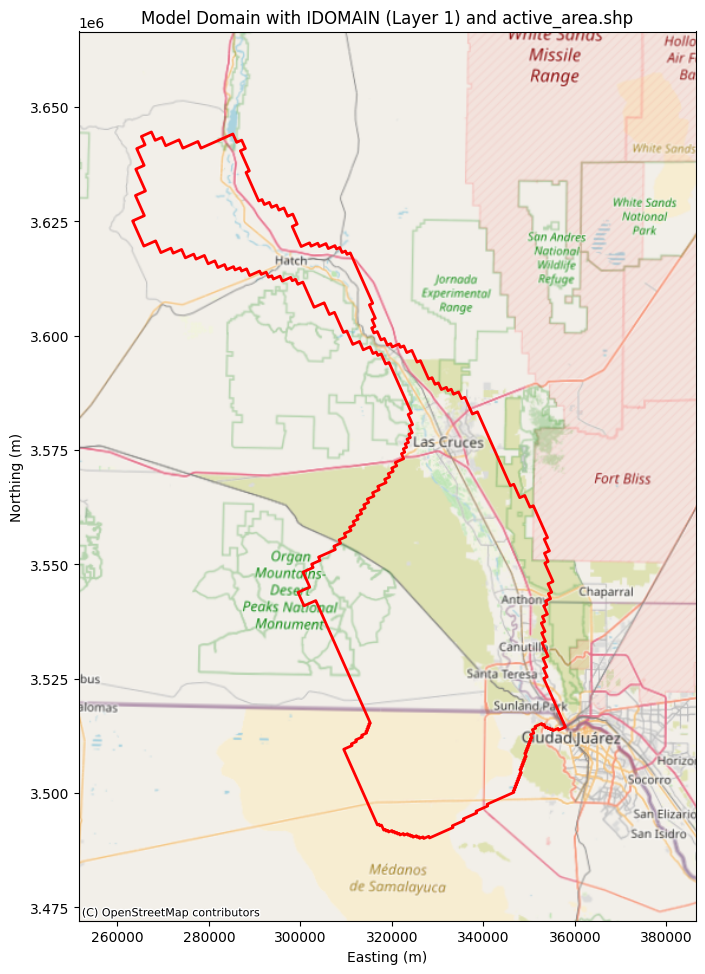

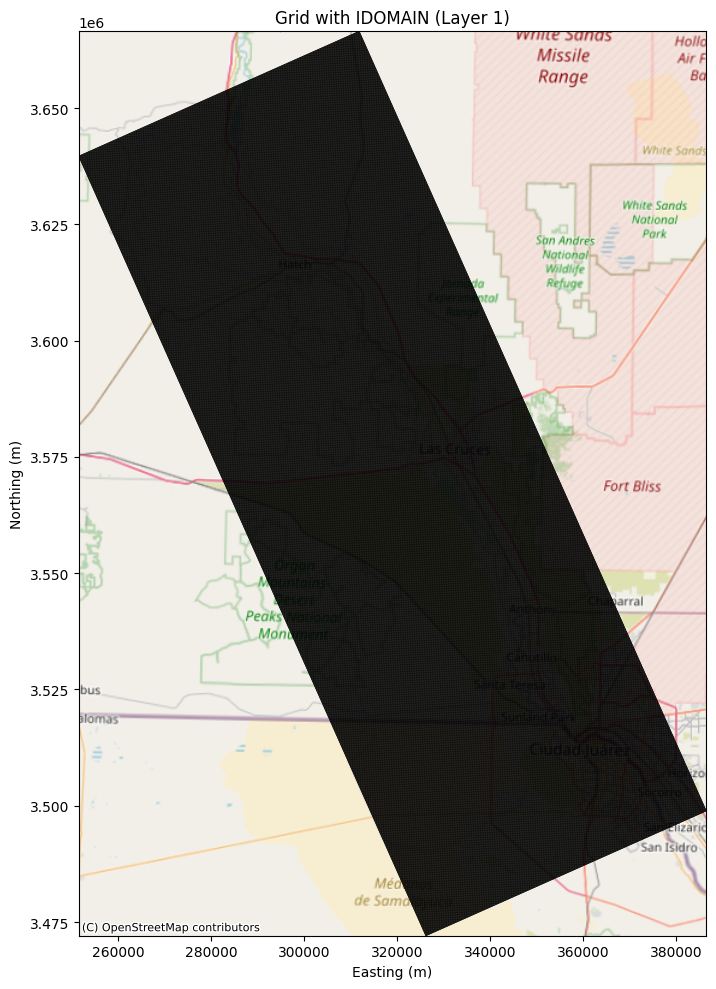

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx

# Extract grid coordinates from DIS package
xll = dis.xorigin.get_data()  # Lower-left x
yll = dis.yorigin.get_data()  # Lower-left y
angrot = dis.angrot.get_data()  # Rotation angle in degrees
delr = dis.delr.get_data()  # Cell widths (array)
delc = dis.delc.get_data()  # Cell heights (array)
ncol = dis.ncol.get_data()  # Number of columns
nrow = dis.nrow.get_data()  # Number of rows
idomain = dis.idomain.get_data()  # 3D IDOMAIN array

# Compute rotated grid coordinates (edges, not centers, for extent)
x = np.arange(ncol + 1) * delr[0]  # +1 for edges
y = np.arange(nrow + 1) * delc[0]  # +1 for edges
X, Y = np.meshgrid(x, y)
X_rot = xll + X * np.cos(np.radians(angrot)) - Y * np.sin(np.radians(angrot))
Y_rot = yll + X * np.sin(np.radians(angrot)) + Y * np.cos(np.radians(angrot))

# Load active area shapefile (assuming gdf is gdf_active from earlier)
gdf = gpd.read_file('./shps/active_area.shp')
if gdf.crs != model_crs:
    gdf = gdf.to_crs(model_crs)

# 1. Overall model domain with IDOMAIN and shapefile
fig, ax = plt.subplots(figsize=(10, 10))
# Use IDOMAIN for layer 0 (Python index 0, MODFLOW layer 1)
ax.imshow(idomain[0], extent=[X_rot.min(), X_rot.max(), Y_rot.min(), Y_rot.max()], 
          cmap='binary', alpha=0.5)
gdf.plot(ax=ax, edgecolor='red', facecolor='none', linewidth=2)
cx.add_basemap(ax, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_title('Model Domain with IDOMAIN (Layer 1) and active_area.shp')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
plt.tight_layout()
plt.show()

# 2. Grid outline with IDOMAIN
fig, ax = plt.subplots(figsize=(10, 10))
cmap = plt.cm.colors.ListedColormap(['white', 'lightgrey'])
bounds = [0, 1, 2]
norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
ax.imshow(idomain[0], extent=[X_rot.min(), X_rot.max(), Y_rot.min(), Y_rot.max()], 
          cmap=cmap, norm=norm, alpha=0.8, interpolation='nearest')
gdf.plot(ax=ax, edgecolor='lightgrey', facecolor='none', linewidth=2, alpha=0.5)

# Plot grid lines using edge coordinates
for i in range(nrow + 1):  # +1 for edges
    ax.plot(X_rot[i, :], Y_rot[i, :], 'k-', lw=0.5)
for j in range(ncol + 1):  # +1 for edges
    ax.plot(X_rot[:, j], Y_rot[:, j], 'k-', lw=0.5)

cx.add_basemap(ax, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
ax.set_title('Grid with IDOMAIN (Layer 1)')
ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
plt.tight_layout()
plt.show()

MF-OWHM row 538 -> MODFLOW 6 row 374
MF-OWHM row 741 -> MODFLOW 6 row 171
MF-OWHM row 103 -> MODFLOW 6 row 809
MF-OWHM col 75 -> MODFLOW 6 col 74
botm shape: (9, 912, 328)
top shape: (912, 328)
x_rot shape: (913, 329)
y_rot shape: (913, 329)
Row OWHM 538 (MF6 374), Layer top rc2: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 538 (MF6 374), Layer top usf1: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 538 (MF6 374), Layer top usf2: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 538 (MF6 374), Layer top msf1: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 538 (MF6 374), Layer top msf2: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 538 (MF6 374), Layer top lsf1: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 538 (MF6 374), Layer top lsf2: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 538 (MF6 374), Layer top bsmt: contains exact -304

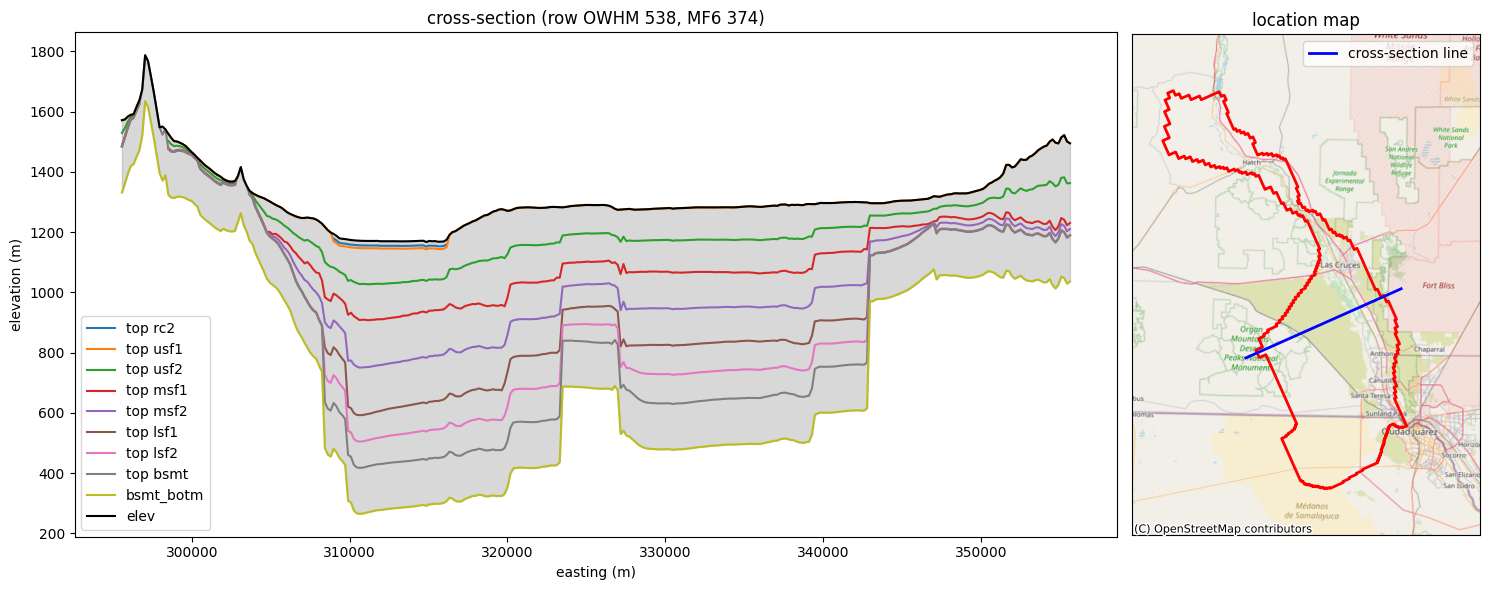

Row OWHM 741 (MF6 171), Layer top rc2: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 741 (MF6 171), Layer top usf1: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 741 (MF6 171), Layer top usf2: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 741 (MF6 171), Layer top msf1: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 741 (MF6 171), Layer top msf2: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 741 (MF6 171), Layer top lsf1: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 741 (MF6 171), Layer top lsf2: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 741 (MF6 171), Layer top bsmt: contains exact -30479.6952=False, close to -30479.6952=False
Row OWHM 741 (MF6 171), Layer bsmt_botm: contains exact -30479.6952=False, close to -30479.6952=False
Row OWHM 741 (MF6 171), Top: contains exact -30479.6952=False, close to -30479.6952=False
inactive

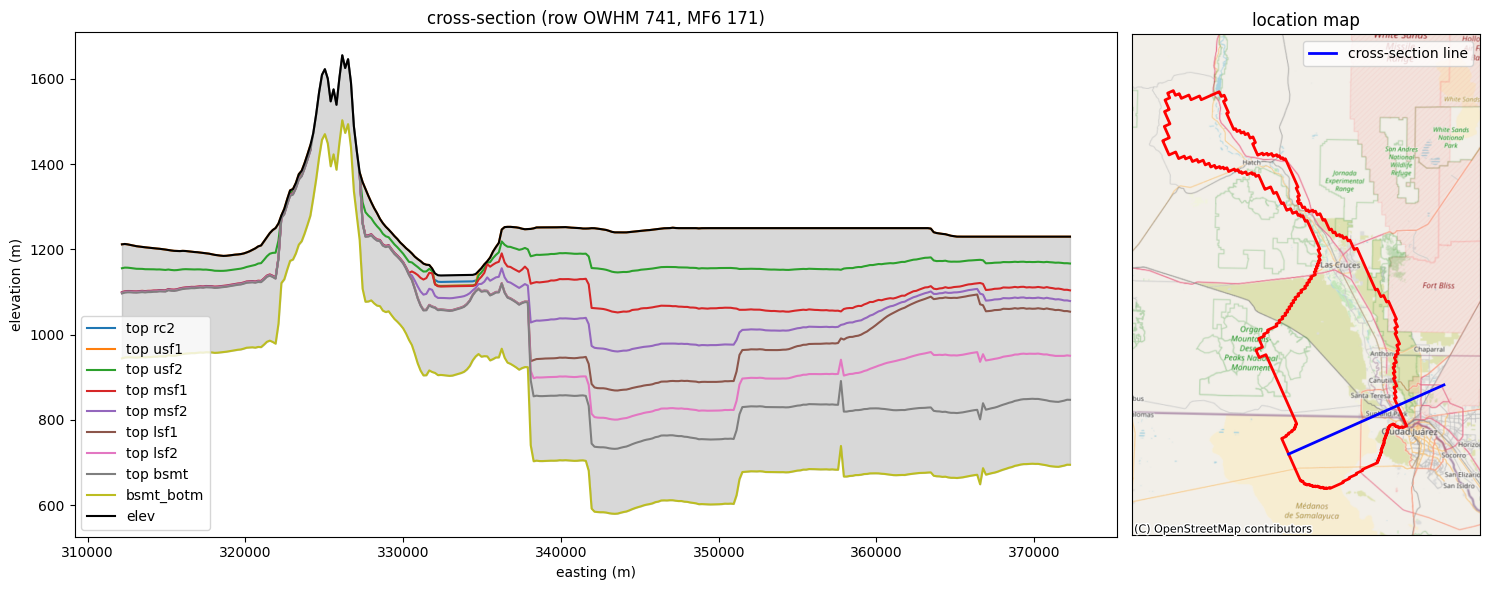

Row OWHM 103 (MF6 809), Layer top rc2: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 103 (MF6 809), Layer top usf1: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 103 (MF6 809), Layer top usf2: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 103 (MF6 809), Layer top msf1: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 103 (MF6 809), Layer top msf2: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 103 (MF6 809), Layer top lsf1: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 103 (MF6 809), Layer top lsf2: contains exact -30479.6952=False, close to -30479.6952=True
Row OWHM 103 (MF6 809), Layer top bsmt: contains exact -30479.6952=False, close to -30479.6952=False
Row OWHM 103 (MF6 809), Layer bsmt_botm: contains exact -30479.6952=False, close to -30479.6952=False
Row OWHM 103 (MF6 809), Top: contains exact -30479.6952=False, close to -30479.6952=False
inactive

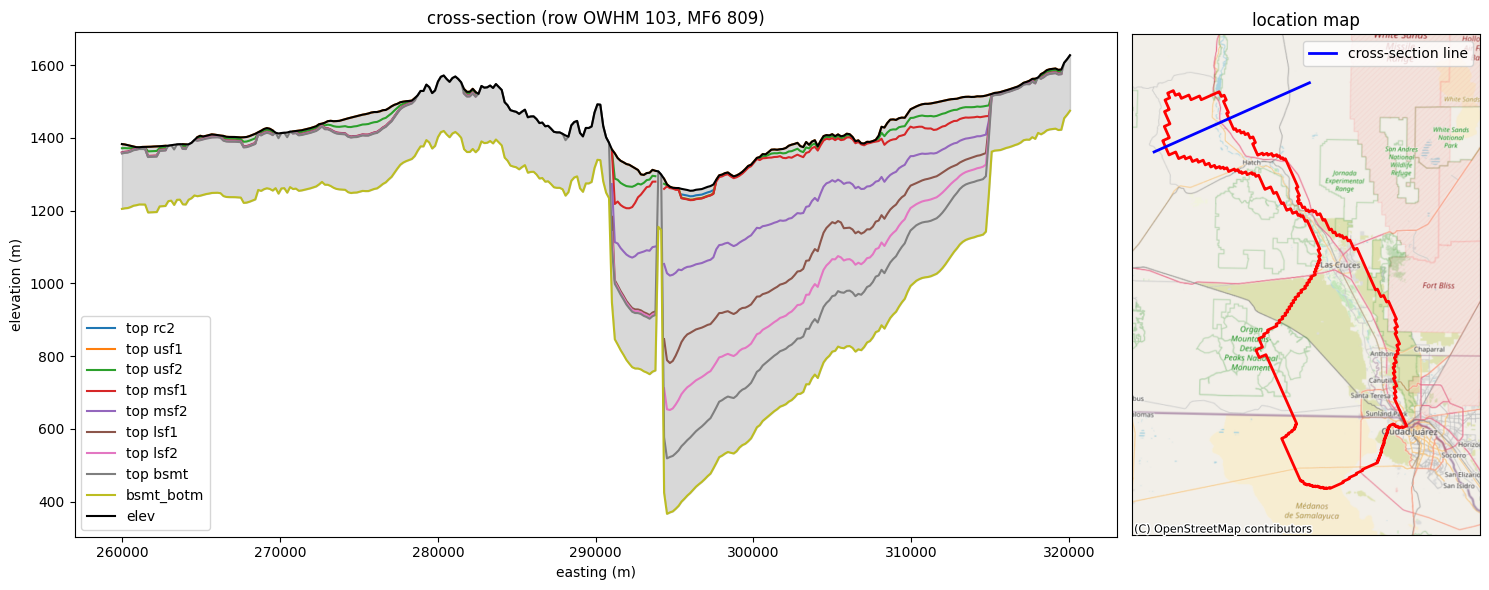

Col OWHM 75 (MF6 74), Layer top rc2: contains exact -30479.6952=False, close to -30479.6952=True
Col OWHM 75 (MF6 74), Layer top usf1: contains exact -30479.6952=False, close to -30479.6952=True
Col OWHM 75 (MF6 74), Layer top usf2: contains exact -30479.6952=False, close to -30479.6952=True
Col OWHM 75 (MF6 74), Layer top msf1: contains exact -30479.6952=False, close to -30479.6952=True
Col OWHM 75 (MF6 74), Layer top msf2: contains exact -30479.6952=False, close to -30479.6952=True
Col OWHM 75 (MF6 74), Layer top lsf1: contains exact -30479.6952=False, close to -30479.6952=True
Col OWHM 75 (MF6 74), Layer top lsf2: contains exact -30479.6952=False, close to -30479.6952=True
Col OWHM 75 (MF6 74), Layer top bsmt: contains exact -30479.6952=False, close to -30479.6952=True
Col OWHM 75 (MF6 74), Layer bsmt_botm: contains exact -30479.6952=False, close to -30479.6952=True
Col OWHM 75 (MF6 74), Top: contains exact -30479.6952=False, close to -30479.6952=False
inactive cells in column OWHM 

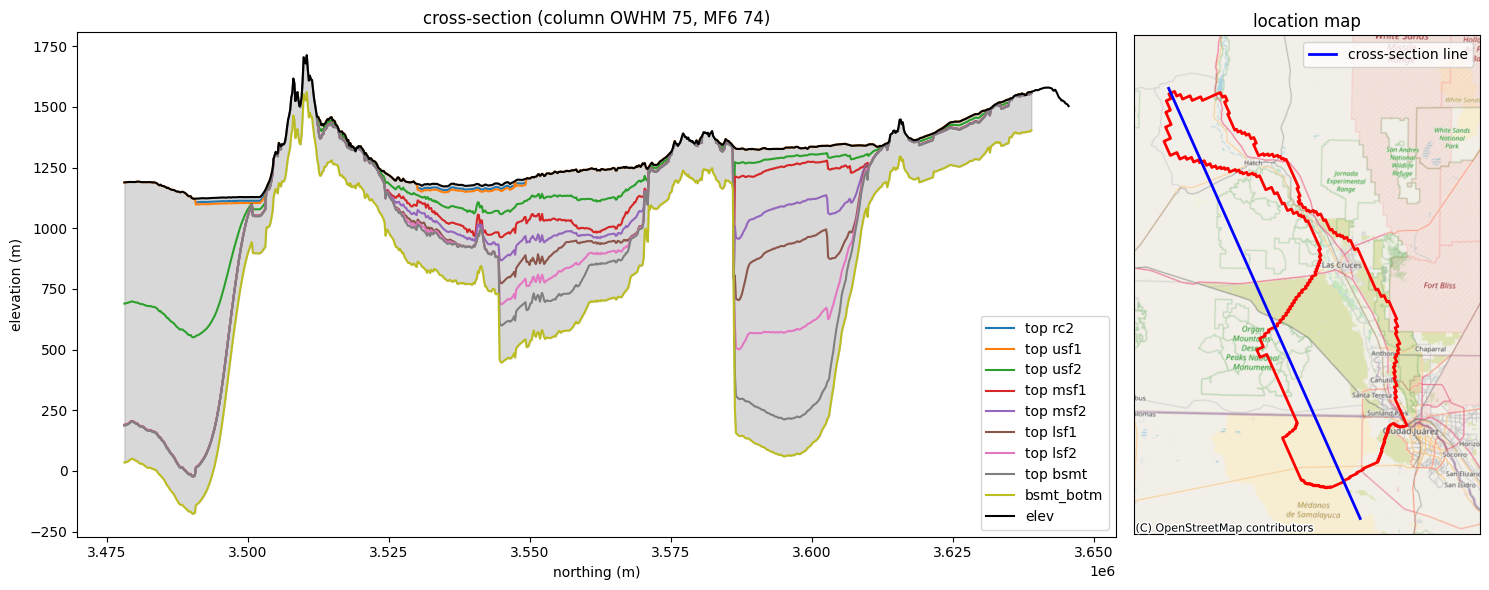

In [10]:
# cross-sections for rows 538, 741, 103 (MF-OWHM convention), and column 75 (MF-OWHM convention)
rows_owhm = [538, 741, 103]  # 1-based, top-down (MF-OWHM)
col_owhm = 75  # 1-based (MF-OWHM)

# Convert MF-OWHM indices to MODFLOW 6 indices
# Assuming nrow_owhm and ncol_owhm are defined (from DIS setup)
nrow_owhm = 912
ncol_owhm = 328

# Transform rows (top-down, 1-based to bottom-up, 0-based)
rows_mf6 = [nrow_owhm - 1 - (row - 1) for row in rows_owhm]
# Transform column (1-based to 0-based, no flipping needed for columns)
col_mf6 = col_owhm - 1

# Print the conversions for reference
for row_owhm, row_mf6 in zip(rows_owhm, rows_mf6):
    print(f"MF-OWHM row {row_owhm} -> MODFLOW 6 row {row_mf6}")
print(f"MF-OWHM col {col_owhm} -> MODFLOW 6 col {col_mf6}")

layer_names = ["top rc2", "top usf1", "top usf2", 
               "top msf1", "top msf2", "top lsf1", "top lsf2", 
               "top bsmt", "bsmt_botm"]

print("botm shape:", botm.shape)
print("top shape:", top.shape)
print("x_rot shape:", X_rot.shape)
print("y_rot shape:", Y_rot.shape)

# no-data sentinel in meters (approx -99999 feet * 0.3048)
no_data_sentinel = -30479.6952
tolerance = 1.0  # tolerance in meters to catch floating-point variations

# debug function to check for sentinel values
def check_sentinel(data, sentinel, label):
    close_to_sentinel = np.any(np.abs(data - sentinel) < tolerance)
    exact_sentinel = np.any(data == sentinel)
    print(f"{label}: contains exact {sentinel}={exact_sentinel}, close to {sentinel}={close_to_sentinel}")

# Plot cross-sections for each row
for row_owhm, row_mf6 in zip(rows_owhm, rows_mf6):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})

    x_trimmed = X_rot[row_mf6, :ncol]
    for lay, name in zip(range(nlay), layer_names):
        bot = botm[lay, row_mf6, :]
        check_sentinel(bot, no_data_sentinel, f"Row OWHM {row_owhm} (MF6 {row_mf6}), Layer {name}")
        bot_plot = np.where(np.abs(bot - no_data_sentinel) < tolerance, np.nan, bot)
        ax1.plot(x_trimmed, bot_plot, label=name)

    top_data = top[row_mf6, :]
    check_sentinel(top_data, no_data_sentinel, f"Row OWHM {row_owhm} (MF6 {row_mf6}), Top")
    top_plot = np.where(np.abs(top_data - no_data_sentinel) < tolerance, np.nan, top_data)
    ax1.plot(x_trimmed, top_plot, 'k-', label='elev')

    inactive_cells = [(name, (idomain[lay, row_mf6, :] == 0).sum()) for lay, name in enumerate(layer_names)]
    print(f"inactive cells in row OWHM {row_owhm} (MF6 {row_mf6}): {inactive_cells}")

    botm_base = np.where(np.abs(botm[-1, row_mf6, :] - no_data_sentinel) < tolerance, np.nan, botm[-1, row_mf6, :])
    top_fill = np.where(np.abs(top[row_mf6, :] - no_data_sentinel) < tolerance, np.nan, top[row_mf6, :])
    valid_mask = ~np.isnan(botm_base) & ~np.isnan(top_fill)
    ax1.fill_between(x_trimmed[valid_mask], botm_base[valid_mask], top_fill[valid_mask], color='gray', alpha=0.3)

    ax1.set_title(f'cross-section (row OWHM {row_owhm}, MF6 {row_mf6})')
    ax1.set_xlabel('easting (m)')
    ax1.set_ylabel('elevation (m)')
    ax1.legend()

    ax2.imshow(idomain[0], extent=[X_rot.min(), X_rot.max(), Y_rot.min(), Y_rot.max()], cmap='binary', alpha=0.5)
    gdf.plot(ax=ax2, edgecolor='red', facecolor='none', linewidth=2)
    cx.add_basemap(ax=ax2, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
    ax2.plot(X_rot[row_mf6, :], Y_rot[row_mf6, :], 'b-', lw=2, label='cross-section line')
    ax2.set_title('location map')
    ax2.legend()
    ax2.set_xticks([])
    ax2.set_yticks([])
    plt.tight_layout()
    plt.show()

# Plot cross-section for the column
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), gridspec_kw={'width_ratios': [3, 1]})

y_trimmed = Y_rot[:nrow, col_mf6]
for lay, name in zip(range(nlay), layer_names):
    bot = botm[lay, :, col_mf6]
    check_sentinel(bot, no_data_sentinel, f"Col OWHM {col_owhm} (MF6 {col_mf6}), Layer {name}")
    bot_plot = np.where(np.abs(bot - no_data_sentinel) < tolerance, np.nan, bot)
    ax1.plot(y_trimmed, bot_plot, label=name)

top_data = top[:, col_mf6]
check_sentinel(top_data, no_data_sentinel, f"Col OWHM {col_owhm} (MF6 {col_mf6}), Top")
top_plot = np.where(np.abs(top_data - no_data_sentinel) < tolerance, np.nan, top_data)
ax1.plot(y_trimmed, top_plot, 'k-', label='elev')

inactive_cells_col = [(name, (idomain[lay, :, col_mf6] == 0).sum()) for lay, name in enumerate(layer_names)]
print(f"inactive cells in column OWHM {col_owhm} (MF6 {col_mf6}): {inactive_cells_col}")

botm_base = np.where(np.abs(botm[-1, :, col_mf6] - no_data_sentinel) < tolerance, np.nan, botm[-1, :, col_mf6])
top_fill = np.where(np.abs(top[:, col_mf6] - no_data_sentinel) < tolerance, np.nan, top[:, col_mf6])
valid_mask = ~np.isnan(botm_base) & ~np.isnan(top_fill)
ax1.fill_between(y_trimmed[valid_mask], botm_base[valid_mask], top_fill[valid_mask], color='gray', alpha=0.3)

ax1.set_title(f'cross-section (column OWHM {col_owhm}, MF6 {col_mf6})')
ax1.set_xlabel('northing (m)')
ax1.set_ylabel('elevation (m)')
ax1.legend()

ax2.imshow(idomain[0], extent=[X_rot.min(), X_rot.max(), Y_rot.min(), Y_rot.max()], cmap='binary', alpha=0.5)
gdf.plot(ax=ax2, edgecolor='red', facecolor='none', linewidth=2)
cx.add_basemap(ax=ax2, crs=model_crs, source=cx.providers.OpenStreetMap.Mapnik)
ax2.plot(X_rot[:, col_mf6], Y_rot[:, col_mf6], 'b-', lw=2, label='cross-section line')
ax2.set_title('location map')
ax2.legend()
ax2.set_xticks([])
ax2.set_yticks([])
plt.tight_layout()
plt.show()